In [1]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

# downloading the data
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50#Constituents')[2]
symbols_list = nifty50['Symbol'].unique().tolist()

# Add '.NS' to each ticker symbol in the list
symbols_list = [ticker + '.NS' for ticker in symbols_list]

# Display the modified list
print(symbols_list)


end_date = '2023-12-03'

start_date = pd.to_datetime(end_date)-pd.DateOffset(365*8)

df = yf.download(tickers=symbols_list,
                 start=start_date,
                 end=end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

['ADANIENT.NS', 'ADANIPORTS.NS', 'APOLLOHOSP.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJAJ-AUTO.NS', 'BAJFINANCE.NS', 'BAJAJFINSV.NS', 'BPCL.NS', 'BHARTIARTL.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'COALINDIA.NS', 'DIVISLAB.NS', 'DRREDDY.NS', 'EICHERMOT.NS', 'GRASIM.NS', 'HCLTECH.NS', 'HDFCBANK.NS', 'HDFCLIFE.NS', 'HEROMOTOCO.NS', 'HINDALCO.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'INDUSINDBK.NS', 'INFY.NS', 'ITC.NS', 'JSWSTEEL.NS', 'KOTAKBANK.NS', 'LT.NS', 'LTIM.NS', 'M&M.NS', 'MARUTI.NS', 'NESTLEIND.NS', 'NTPC.NS', 'ONGC.NS', 'POWERGRID.NS', 'RELIANCE.NS', 'SBILIFE.NS', 'SBIN.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS', 'TATASTEEL.NS', 'TCS.NS', 'TATACONSUM.NS', 'TECHM.NS', 'TITAN.NS', 'ULTRACEMCO.NS', 'UPL.NS', 'WIPRO.NS']
[*********************100%%**********************]  50 of 50 completed


adj close        close         high          low  \
date       ticker                                                              
2015-12-07 ADANIENT.NS      41.885918    43.210667    44.000774    43.047195   
           ADANIPORTS.NS   243.889099   255.100006   258.899994   254.500000   
           APOLLOHOSP.NS  1332.384033  1370.599976  1389.650024  1365.849976   
           ASIANPAINT.NS   825.444946   871.450012   873.849976   841.000000   
           AXISBANK.NS     451.848602   462.299988   465.549988   460.299988   
...                               ...          ...          ...          ...   
2023-12-01 TECHM.NS       1220.550049  1220.550049  1226.800049  1211.550049   
           TITAN.NS       3489.500000  3489.500000  3500.000000  3470.000000   
           ULTRACEMCO.NS  9033.849609  9033.849609  9163.400391  8972.000000   
           UPL.NS          575.150024   575.150024   575.950012   569.049988   
           WIPRO.NS        407.649994   407.649994   413.750000   406.500000   

                                 open     volume  
date       ticker                                 
2015-12-07 ADANIENT.NS      43.292400  2366502.0  
           ADANIPORTS.NS   257.850006  2699537.0  
           APOLLOHOSP.NS  1370.300049   135849.0  
           ASIANPAINT.NS   842.000000  1602605.0  
           AXISBANK.NS     462.950012  6335649.0  
...                               ...        ...  
2023-12-01 TECHM.NS       1226.800049  1017856.0  
           TITAN.NS       3499.000000   655263.0  
           ULTRACEMCO.NS  9103.799805   353015.0  
           UPL.NS          570.650024  1811072.0  
           WIPRO.NS        413.750000  4915213.0  

[97614 rows x 6 columns]

### Calculate features and technical indicators

* Garman -klass volatilit
* RSI
* Bollinger Bands
* ATR
* MACD
* Dollar Volume

In [2]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6

df

adj close        close         high          low  \
date       ticker                                                              
2015-12-07 ADANIENT.NS      41.885918    43.210667    44.000774    43.047195   
           ADANIPORTS.NS   243.889099   255.100006   258.899994   254.500000   
           APOLLOHOSP.NS  1332.384033  1370.599976  1389.650024  1365.849976   
           ASIANPAINT.NS   825.444946   871.450012   873.849976   841.000000   
           AXISBANK.NS     451.848602   462.299988   465.549988   460.299988   
...                               ...          ...          ...          ...   
2023-12-01 TECHM.NS       1220.550049  1220.550049  1226.800049  1211.550049   
           TITAN.NS       3489.500000  3489.500000  3500.000000  3470.000000   
           ULTRACEMCO.NS  9033.849609  9033.849609  9163.400391  8972.000000   
           UPL.NS          575.150024   575.150024   575.950012   569.049988   
           WIPRO.NS        407.649994   407.649994   413.750000   406.500000   

                                 open     volume  garman_klass_vol        rsi  \
date       ticker                                                               
2015-12-07 ADANIENT.NS      43.292400  2366502.0         -0.000181        NaN   
           ADANIPORTS.NS   257.850006  2699537.0         -0.001050        NaN   
           APOLLOHOSP.NS  1370.300049   135849.0         -0.000155        NaN   
           ASIANPAINT.NS   842.000000  1602605.0          0.000582        NaN   
           AXISBANK.NS     462.950012  6335649.0         -0.000163        NaN   
...                               ...        ...               ...        ...   
2023-12-01 TECHM.NS       1226.800049  1017856.0          0.000068  58.581859   
           TITAN.NS       3499.000000   655263.0          0.000034  67.655984   
           ULTRACEMCO.NS  9103.799805   353015.0          0.000200  65.031669   
           UPL.NS          570.650024  1811072.0          0.000049  50.550411   
           WIPRO.NS        413.750000  4915213.0          0.000071  56.628958   

                            bb_low    bb_mid   bb_high       atr      macd  \
date       ticker                                                            
2015-12-07 ADANIENT.NS         NaN       NaN       NaN       NaN       NaN   
           ADANIPORTS.NS       NaN       NaN       NaN       NaN       NaN   
           APOLLOHOSP.NS       NaN       NaN       NaN       NaN       NaN   
           ASIANPAINT.NS       NaN       NaN       NaN       NaN       NaN   
           AXISBANK.NS         NaN       NaN       NaN       NaN       NaN   
...                            ...       ...       ...       ...       ...   
2023-12-01 TECHM.NS       7.007478  7.071993  7.136507 -0.063900  0.651981   
           TITAN.NS       8.066861  8.115641  8.164421  0.934383  1.711102   
           ULTRACEMCO.NS  9.041387  9.071900  9.102412  0.575865  1.069551   
           UPL.NS         6.297556  6.327645  6.357735 -1.489782 -0.300014   
           WIPRO.NS       5.926089  5.976878  6.027667 -0.195633  0.311411   

                          dollar_volume  
date       ticker                        
2015-12-07 ADANIENT.NS        99.123108  
           ADANIPORTS.NS     658.387647  
           APOLLOHOSP.NS     181.003039  
           ASIANPAINT.NS    1322.862198  
           AXISBANK.NS      2862.754145  
...                                 ...  
2023-12-01 TECHM.NS         1242.344190  
           TITAN.NS         2286.540239  
           ULTRACEMCO.NS    3189.084420  
           UPL.NS           1041.638105  
           WIPRO.NS         2003.686549  

[97614 rows x 14 columns]

# Taking First 30 Companies beacuse also listed in Sensex

## Getting monthly index and average dollar volume and making it multiindex

In [3]:
last_cols =[c for c in df.columns.unique(0)if c not in['dollar_volume','volume','open','high','low','close']]
last_cols
data=pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
df.unstack()[last_cols].resample('M').last().stack('ticker')],axis=1).dropna()
data

dollar_volume    adj close  garman_klass_vol  \
date       ticker                                                        
2016-01-31 ADANIENT.NS       300.061188    38.479057          0.000807   
           ADANIPORTS.NS     866.942010   202.922241          0.000095   
           APOLLOHOSP.NS     286.908192  1431.928833          0.001129   
           ASIANPAINT.NS    1137.570587   823.976624         -0.000699   
           AXISBANK.NS      4741.544789   399.167114          0.000825   
...                                 ...          ...               ...   
2023-12-31 TECHM.NS         1242.344190  1220.550049          0.000068   
           TITAN.NS         2286.540239  3489.500000          0.000034   
           ULTRACEMCO.NS    3189.084420  9033.849609          0.000200   
           UPL.NS           1041.638105   575.150024          0.000049   
           WIPRO.NS         2003.686549   407.649994          0.000071   

                                rsi    bb_low    bb_mid   bb_high       atr  \
date       ticker                                                             
2016-01-31 ADANIENT.NS    42.839206  3.578264  3.736252  3.894239 -0.682200   
           ADANIPORTS.NS  32.391060  5.267337  5.403601  5.539864 -0.758040   
           APOLLOHOSP.NS  59.593925  7.162149  7.218003  7.273858 -0.543770   
           ASIANPAINT.NS  50.141892  6.679449  6.714974  6.750498 -1.007063   
           AXISBANK.NS    43.700828  5.899631  5.995922  6.092213 -0.343651   
...                             ...       ...       ...       ...       ...   
2023-12-31 TECHM.NS       58.581859  7.007478  7.071993  7.136507 -0.063900   
           TITAN.NS       67.655984  8.066861  8.115641  8.164421  0.934383   
           ULTRACEMCO.NS  65.031669  9.041387  9.071900  9.102412  0.575865   
           UPL.NS         50.550411  6.297556  6.327645  6.357735 -1.489782   
           WIPRO.NS       56.628958  5.926089  5.976878  6.027667 -0.195633   

                              macd  
date       ticker                   
2016-01-31 ADANIENT.NS   -0.137571  
           ADANIPORTS.NS -0.951670  
           APOLLOHOSP.NS -0.200812  
           ASIANPAINT.NS -0.294414  
           AXISBANK.NS   -0.764298  
...                            ...  
2023-12-31 TECHM.NS       0.651981  
           TITAN.NS       1.711102  
           ULTRACEMCO.NS  1.069551  
           UPL.NS        -0.300014  
           WIPRO.NS       0.311411  

[4748 rows x 9 columns]

In [4]:
data['dollar_volume'].unstack('ticker').rolling(5*12).mean()

ticker      ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
date                                                                   
2016-01-31          NaN            NaN            NaN            NaN   
2016-02-29          NaN            NaN            NaN            NaN   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-08-31  5147.314142    4326.666959    2274.496065    3407.077508   
2023-09-30  5235.324907    4404.255264    2294.886481    3428.879778   
2023-10-31  5273.545519    4424.021198    2317.775248    3445.224795   
2023-11-30  5338.582174    4459.059992    2344.079975    3456.371743   
2023-12-31  5396.785607    4476.727133    2383.648032    3474.959811   

ticker      AXISBANK.NS  BAJAJ-AUTO.NS  BAJAJFINSV.NS  BAJFINANCE.NS  \
date                                                                   
2016-01-31          NaN            NaN            NaN            NaN   
2016-02-29          NaN            NaN            NaN            NaN   
2016-03-31          NaN            NaN            NaN            NaN   
2016-04-30          NaN            NaN            NaN            NaN   
2016-05-31          NaN            NaN            NaN            NaN   
...                 ...            ...            ...            ...   
2023-08-31  9115.319317    1626.490018    3853.345382   10264.175098   
2023-09-30  9133.580702    1641.936192    3860.398026   10250.178595   
2023-10-31  9161.581764    1673.417391    3873.913078   10206.815009   
2023-11-30  9174.505842    1701.894306    3891.607961   10290.554304   
2023-12-31  9347.943535    1731.324786    3900.824288   10331.918308   

ticker      BHARTIARTL.NS      BPCL.NS  ...  SUNPHARMA.NS  TATACONSUM.NS  \
date                                    ...                                
2016-01-31            NaN          NaN  ...           NaN            NaN   
2016-02-29            NaN          NaN  ...           NaN            NaN   
2016-03-31            NaN          NaN  ...           NaN            NaN   
2016-04-30            NaN          NaN  ...           NaN            NaN   
2016-05-31            NaN          NaN  ...           NaN            NaN   
...                   ...          ...  ...           ...            ...   
2023-08-31    6373.355944  2245.851513  ...   3534.986093    1409.954911   
2023-09-30    6422.464883  2249.587225  ...   3487.168672    1420.248054   
2023-10-31    6456.075771  2228.405672  ...   3475.186117    1433.615976   
2023-11-30    6485.092011  2249.580151  ...   3444.909786    1450.406263   
2023-12-31    6543.561865  2300.405059  ...   3343.293079    1459.762121   

ticker      TATAMOTORS.NS  TATASTEEL.NS       TCS.NS     TECHM.NS  \
date                                                                
2016-01-31            NaN           NaN          NaN          NaN   
2016-02-29            NaN           NaN          NaN          NaN   
2016-03-31            NaN           NaN          NaN          NaN   
2016-04-30            NaN           NaN          NaN          NaN   
2016-05-31            NaN           NaN          NaN          NaN   
...                   ...           ...          ...          ...   
2023-08-31    9054.068809   7288.859019  7282.735647  2825.229530   
2023-09-30    9088.679345   7302.001933  7317.711394  2843.642541   
2023-10-31    9141.019458   7301.476029  7338.785415  2851.682449   
2023-11-30    9211.177130   7291.275519  7367.597080  2851.936240   
2023-12-31    9294.027475   7308.510635  7363.907956  2848.904846   

ticker         TITAN.NS  ULTRACEMCO.NS       UPL.NS     WIPRO.NS  
date                                                              
2016-01-31          NaN            NaN          NaN          NaN  
2016-02-29          NaN            NaN

In [5]:
data['dollar_vol_rank']= (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_vol_rank']<30].drop(['dollar_volume','dollar_vol_rank'],axis=1)

In [6]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2016-01-31 ADANIPORTS.NS   202.922241          0.000095  32.391060  5.267337   
           ASIANPAINT.NS   823.976624         -0.000699  50.141892  6.679449   
           AXISBANK.NS     399.167114          0.000825  43.700828  5.899631   
           BHARTIARTL.NS   255.799362          0.000781  31.669912  5.535999   
           BPCL.NS         195.432068         -0.058725  49.383181  5.247051   
...                               ...               ...        ...       ...   
2023-12-31 SBIN.NS         571.750000          0.000063  49.651621  6.319633   
           TATAMOTORS.NS   705.450012          0.000059  66.415798  6.441771   
           TATASTEEL.NS    130.000000          0.000124  64.267123  4.763704   
           TCS.NS         3511.649902          0.000025  55.050350  8.100732   
           ULTRACEMCO.NS  9033.849609          0.000200  65.031669  9.041387   

                            bb_mid   bb_high       atr      macd  
date       ticker                                                 
2016-01-31 ADANIPORTS.NS  5.403601  5.539864 -0.758040 -0.951670  
           ASIANPAINT.NS  6.714974  6.750498 -1.007063 -0.294414  
           AXISBANK.NS    5.995922  6.092213 -0.343651 -0.764298  
           BHARTIARTL.NS  5.618069  5.700139 -0.821280 -0.952871  
           BPCL.NS        5.279657  5.312263 -0.788378 -0.262203  
...                            ...       ...       ...       ...  
2023-12-31 SBIN.NS        6.349924  6.380216 -0.564026 -0.500292  
           TATAMOTORS.NS  6.509480  6.577189  0.780871  1.497857  
           TATASTEEL.NS   4.823854  4.884004 -0.129775  0.657972  
           TCS.NS         8.142842  8.184952 -0.036509  0.266453  
           ULTRACEMCO.NS  9.071900  9.102412  0.575865  1.069551  

[2784 rows x 8 columns]

# Calculate Monthly returns for different time horizion features
* TO capture time series dynamics that reflects ,for example,momentum patterns, we compute historical returns using the method .pct_change(lag) that is, returns over various monthly periods as identified by lags

In [7]:
def calculate_returns(df):
    
   
    outlier_cutoff =0.005
    lags=[1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m']=(df['adj close']
                            .pct_change(lag)
                            .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),upper=x.quantile(1-outlier_cutoff)))
                            .add(1)
                            .pow(1/lag)
                            .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                              
2017-01-31 AXISBANK.NS     459.724060         -0.000133  50.399413  6.069462   
           HCLTECH.NS      342.984894         -0.013065  45.978354  5.848096   
           HDFCBANK.NS     612.751770         -0.000721  67.618823  6.324470   
           ICICIBANK.NS    235.550507         -0.000131  55.501089  5.398469   
           INDUSINDBK.NS  1202.090210         -0.000346  65.374084  6.966738   
...                               ...               ...        ...       ...   
2023-12-31 SBIN.NS         571.750000          0.000063  49.651621  6.319633   
           TATAMOTORS.NS   705.450012          0.000059  66.415798  6.441771   
           TATASTEEL.NS    130.000000          0.000124  64.267123  4.763704   
           TCS.NS         3511.649902          0.000025  55.050350  8.100732   
           ULTRACEMCO.NS  9033.849609          0.000200  65.031669  9.041387   

                            bb_mid   bb_high       atr      macd  return_1m  \
date       ticker                                                             
2017-01-31 AXISBANK.NS    6.126097  6.182732 -0.967470 -0.003962   0.035671   
           HCLTECH.NS     5.875160  5.902224 -0.842420 -0.111814  -0.020291   
           HDFCBANK.NS    6.379680  6.434890 -1.250169  0.417313   0.066697   
           ICICIBANK.NS   5.444866  5.491263 -1.257621 -0.057290   0.053467   
           INDUSINDBK.NS  7.051620  7.136502 -0.784013  1.036671   0.130111   
...                            ...       ...       ...       ...        ...   
2023-12-31 SBIN.NS        6.349924  6.380216 -0.564026 -0.500292   0.012395   
           TATAMOTORS.NS  6.509480  6.577189  0.780871  1.497857  -0.001345   
           TATASTEEL.NS   4.823854  4.884004 -0.129775  0.657972   0.016419   
           TCS.NS         8.142842  8.184952 -0.036509  0.266453   0.006896   
           ULTRACEMCO.NS  9.071900  9.102412  0.575865  1.069551   0.072617   

                          return_2m  return_3m  return_6m  return_9m  \
date       ticker                                                      
2017-01-31 AXISBANK.NS    -0.004105  -0.014518  -0.026105  -0.000481   
           HCLTECH.NS      0.004562   0.020541   0.015019   0.011301   
           HDFCBANK.NS     0.035648   0.007254   0.005338   0.015217   
           ICICIBANK.NS    0.006381  -0.009604   0.003799   0.016473   
           INDUSINDBK.NS   0.073411   0.014311   0.010549   0.020340   
...                             ...        ...        ...        ...   
2023-12-31 SBIN.NS         0.005466  -0.015153  -0.000320   0.011952   
           TATAMOTORS.NS   0.059324   0.038315   0.029161   0.059455   
           TATASTEEL.NS    0.046297   0.002837   0.025150   0.028220   
           TCS.NS          0.020989  -0.000743   0.011172   0.011587   
           ULTRACEMCO.NS   0.046121   0.030426   0.037862   0.034033   

                          return_12m  
date       ticker                     
2017-01-31 AXISBANK.NS      0.011840  
           HCLTECH.NS      -0.003492  
           HDFCBANK.NS      0.017787  
           ICICIBANK.NS     0.014789  
           INDUSINDBK.NS    0.025552  
...                              ...  
2023-12-31 SBIN.NS         -0.004287  
           TATAMOTORS.NS    0.051365  
           TATASTEEL.NS     0.014721  
           TCS.NS           0.009042  
           ULTRACEMCO.NS    0.041435  

[2228 rows x 14 columns]

## Download Fama-French Factors and Calculate Rolling Factor Betas.
* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [8]:
 factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF',axis=1)
factor_data.index = factor_data.index.to_timestamp()
factor_data= factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'
factor_data = factor_data.join(data['return_1m']).sort_index()
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-01-31 AXISBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.035671
           HCLTECH.NS     0.0194 -0.0146 -0.0275 -0.0049 -0.0099  -0.020291
           HDFCBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.066697
           ICICIBANK.NS   0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.053467
           INDUSINDBK.NS  0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.130111
...                          ...     ...     ...     ...     ...        ...
2023-10-31 TATAMOTORS.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.002460
           TATASTEEL.NS  -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.078743
           TCS.NS        -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.042831
           TECHM.NS      -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.073315
           ULTRACEMCO.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.020279

[2175 rows x 6 columns]

In [9]:
observation = factor_data.groupby(level=1).size()
valid_stocks = observation[observation>=10]
factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]
factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                          
2017-01-31 AXISBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.035671
           HCLTECH.NS     0.0194 -0.0146 -0.0275 -0.0049 -0.0099  -0.020291
           HDFCBANK.NS    0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.066697
           ICICIBANK.NS   0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.053467
           INDUSINDBK.NS  0.0194 -0.0146 -0.0275 -0.0049 -0.0099   0.130111
...                          ...     ...     ...     ...     ...        ...
2023-10-31 TATAMOTORS.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.002460
           TATASTEEL.NS  -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.078743
           TCS.NS        -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.042831
           TECHM.NS      -0.0318 -0.0403  0.0019  0.0247 -0.0066  -0.073315
           ULTRACEMCO.NS -0.0318 -0.0403  0.0019  0.0247 -0.0066   0.020279

[2152 rows x 6 columns]

In [10]:
betas =(factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                         
2017-01-31 AXISBANK.NS         NaN       NaN       NaN       NaN       NaN
           HCLTECH.NS          NaN       NaN       NaN       NaN       NaN
           HDFCBANK.NS         NaN       NaN       NaN       NaN       NaN
           ICICIBANK.NS        NaN       NaN       NaN       NaN       NaN
           INDUSINDBK.NS       NaN       NaN       NaN       NaN       NaN
...                            ...       ...       ...       ...       ...
2023-10-31 TATAMOTORS.NS  0.991649 -0.502251  0.904166 -0.253843 -0.970144
           TATASTEEL.NS   1.097797 -0.019286 -0.009777 -1.187673  0.242953
           TCS.NS         0.480936  0.178337 -0.043327  0.336092  0.150238
           TECHM.NS       0.998339  0.023378 -0.523770  0.536281  0.129543
           ULTRACEMCO.NS  0.896930  0.449133  0.411286  0.717032 -0.586727

[2152 rows x 5 columns]

In [11]:
factors=['Mkt-RF','SMB','HML','RMW','CMA']

data =data.join(betas.groupby('ticker').shift())
data.loc[:,factors] = data.groupby('ticker',group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))
data = data.dropna()
data = data.drop('adj close', axis=1)
data
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 2141 entries, (Timestamp('2017-01-31 00:00:00'), 'AXISBANK.NS') to (Timestamp('2023-12-31 00:00:00'), 'ULTRACEMCO.NS')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  2141 non-null   float64
 1   rsi               2141 non-null   float64
 2   bb_low            2141 non-null   float64
 3   bb_mid            2141 non-null   float64
 4   bb_high           2141 non-null   float64
 5   atr               2141 non-null   float64
 6   macd              2141 non-null   float64
 7   return_1m         2141 non-null   float64
 8   return_2m         2141 non-null   float64
 9   return_3m         2141 non-null   float64
 10  return_6m         2141 non-null   float64
 11  return_9m         2141 non-null   float64
 12  return_12m        2141 non-null   float64
 13  Mkt-RF            2141 non-null   float64
 14  SMB               2141 non-null   float64

# At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
* K-Means Clustering

* You may want to initialize predefined centroids for each cluster based on your research.

* Then we will pre-define our centroids for each cluster.

In [12]:
from sklearn.cluster import KMeans

#data = data.drop('cluster',axis=1) # added later after clustering with random

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_ # changed 'random' to initial centriods
    return df
data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data


garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-01-31 AXISBANK.NS           -0.000133  50.399413  6.069462  6.126097   
           HCLTECH.NS            -0.013065  45.978354  5.848096  5.875160   
           HDFCBANK.NS           -0.000721  67.618823  6.324470  6.379680   
           ICICIBANK.NS          -0.000131  55.501089  5.398469  5.444866   
           INDUSINDBK.NS         -0.000346  65.374084  6.966738  7.051620   
...                                    ...        ...       ...       ...   
2023-12-31 SBIN.NS                0.000063  49.651621  6.319633  6.349924   
           TATAMOTORS.NS          0.000059  66.415798  6.441771  6.509480   
           TATASTEEL.NS           0.000124  64.267123  4.763704  4.823854   
           TCS.NS                 0.000025  55.050350  8.100732  8.142842   
           ULTRACEMCO.NS          0.000200  65.031669  9.041387  9.071900   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-01-31 AXISBANK.NS    6.182732 -0.967470 -0.003962   0.035671  -0.004105   
           HCLTECH.NS     5.902224 -0.842420 -0.111814  -0.020291   0.004562   
           HDFCBANK.NS    6.434890 -1.250169  0.417313   0.066697   0.035648   
           ICICIBANK.NS   5.491263 -1.257621 -0.057290   0.053467   0.006381   
           INDUSINDBK.NS  7.136502 -0.784013  1.036671   0.130111   0.073411   
...                            ...       ...       ...        ...        ...   
2023-12-31 SBIN.NS        6.380216 -0.564026 -0.500292   0.012395   0.005466   
           TATAMOTORS.NS  6.577189  0.780871  1.497857  -0.001345   0.059324   
           TATASTEEL.NS   4.884004 -0.129775  0.657972   0.016419   0.046297   
           TCS.NS         8.184952 -0.036509  0.266453   0.006896   0.020989   
           ULTRACEMCO.NS  9.102412  0.575865  1.069551   0.072617   0.046121   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-01-31 AXISBANK.NS    -0.014518  -0.026105  -0.000481    0.011840   
           HCLTECH.NS      0.020541   0.015019   0.011301   -0.003492   
           HDFCBANK.NS     0.007254   0.005338   0.015217    0.017787   
           ICICIBANK.NS   -0.009604   0.003799   0.016473    0.014789   
           INDUSINDBK.NS   0.014311   0.010549   0.020340    0.025552   
...                             ...        ...        ...         ...   
2023-12-31 SBIN.NS        -0.015153  -0.000320   0.011952   -0.004287   
           TATAMOTORS.NS   0.038315   0.029161   0.059455    0.051365   
           TATASTEEL.NS    0.002837   0.025150   0.028220    0.014721   
           TCS.NS         -0.000743   0.011172   0.011587    0.009042   
           ULTRACEMCO.NS   0.030426   0.037862   0.034033    0.041435   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-01-31 AXISBANK.NS    0.863364  0.232647  0.373941 -0.420440  0.057822   
           HCLTECH.NS     0.967453 -0.644320  0.205449 -0.280619  0.060663   
           HDFCBANK.NS    0.457319  0.378685  0.139145 -0.030581  0.215997   
           ICICIBANK.NS   0.737378 -0.675218  0.798534 -0.306121 -0.440757   
           INDUSINDBK.NS  1.054514  0.305098  0.374737 -0.998176 -0.013994   
...                            ...       ...       ...       ...       ...   
2023-12-31 SBIN.NS        0.563377 -0.350393  0.950826 -0.764198 -0.420912   
           TATAMOTORS.NS  1.252771  0.518702  0.912426  0.746826 -0.615039   
           TATASTEEL.NS   1.119001 -0.262106  0.679456 -0.213079 -0.682841   
           TCS.NS         0.480291 -0.070394 -0.156244 -0.327033  0.149681   
           ULTRACEMCO.NS  0.452557  0.544326  0.647770  1.287276 -1.392334   

                  

In [13]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]
# the impoertant thing we are chosing which column iloc[:,5] is atr and 1 is rsi
    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
# labeling
    x_label = data.columns[5]
    y_label = data.columns[1]
    plt.title(f'Clusters based on {x_label} and {y_label}')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.show()
    return

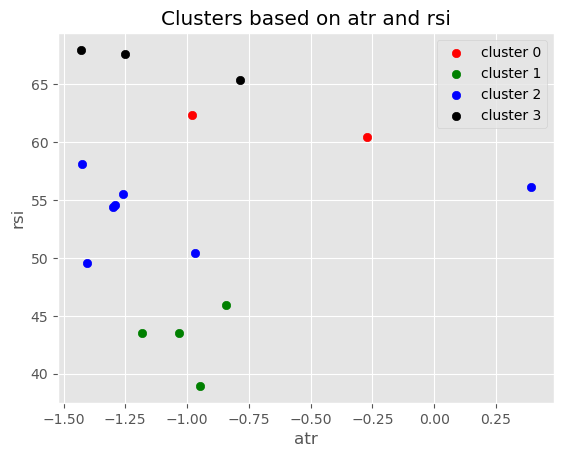

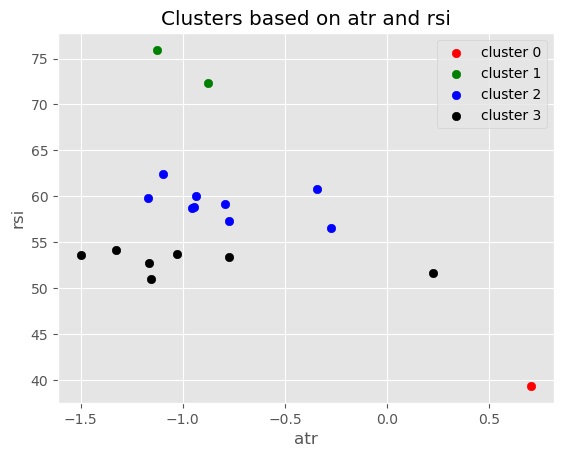

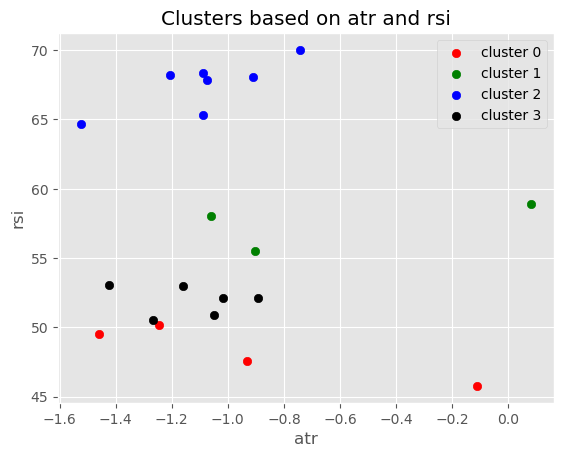

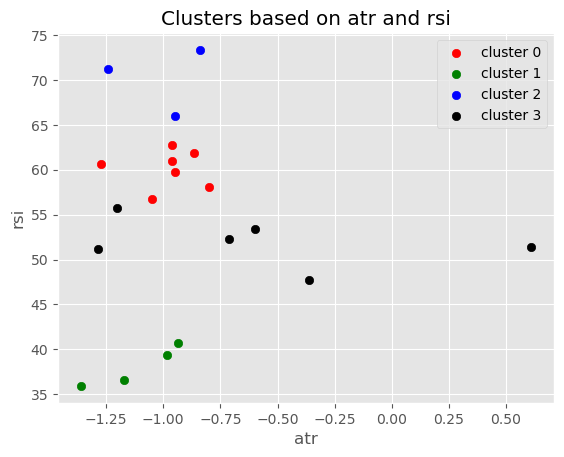

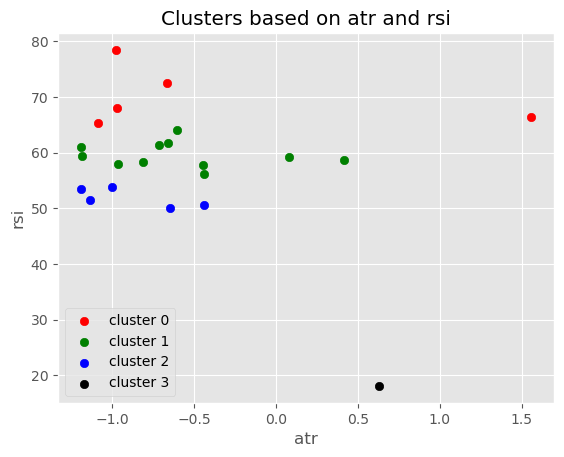

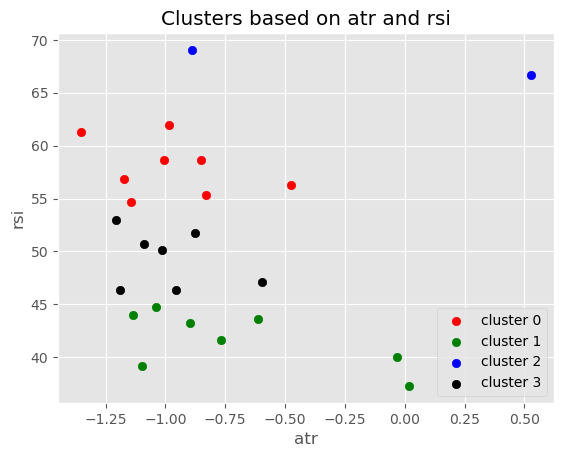

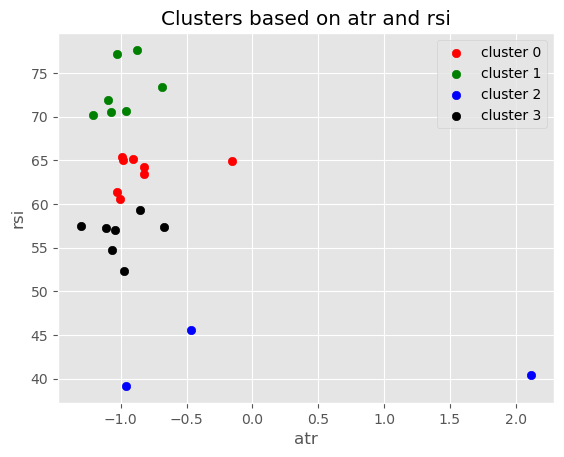

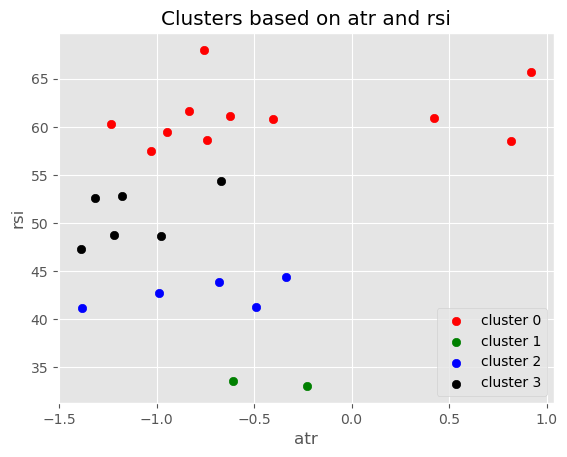

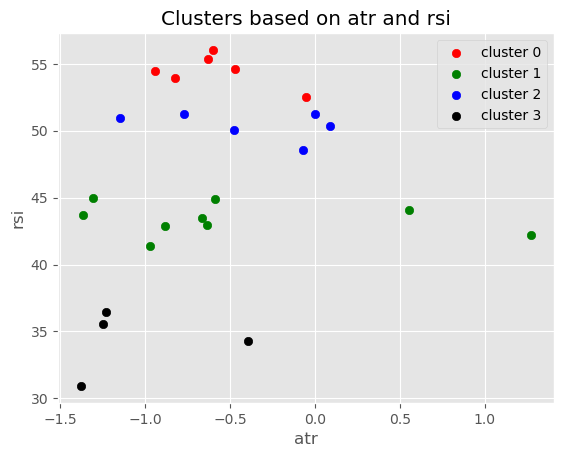

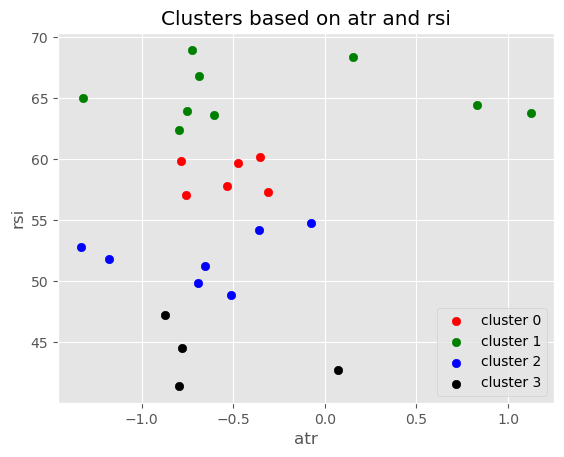

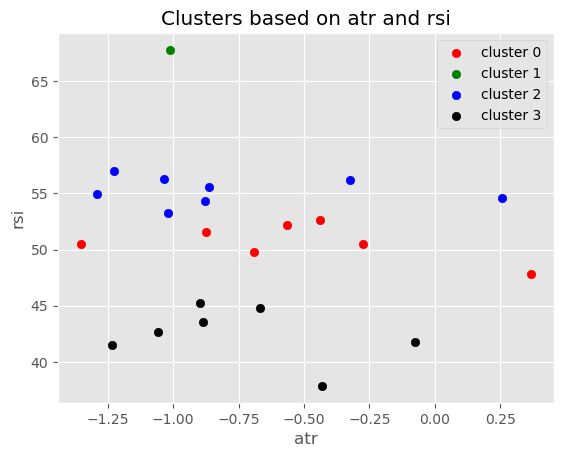

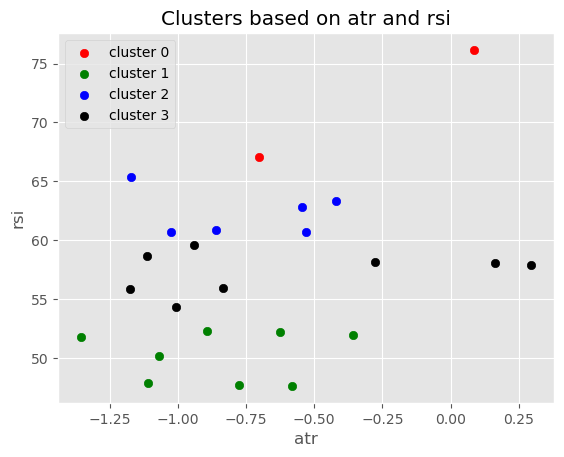

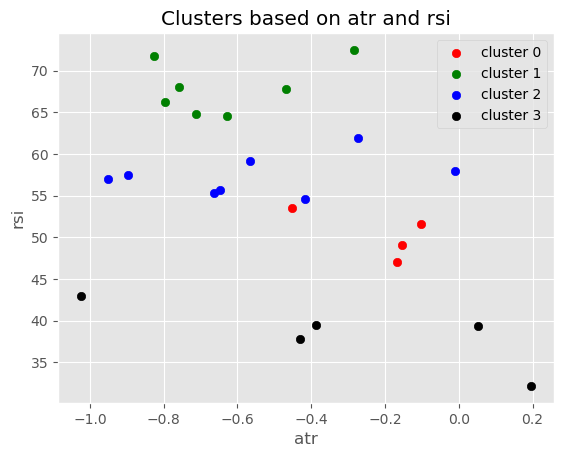

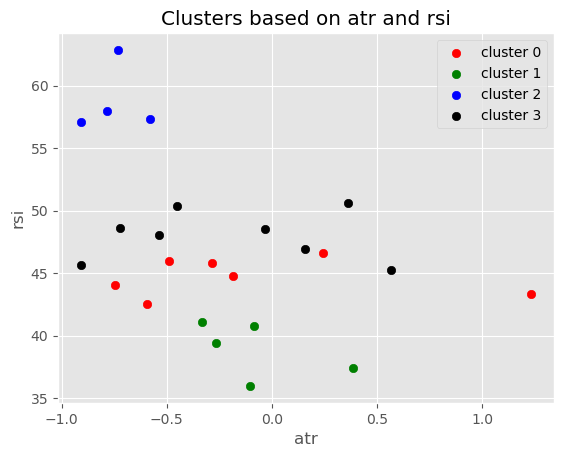

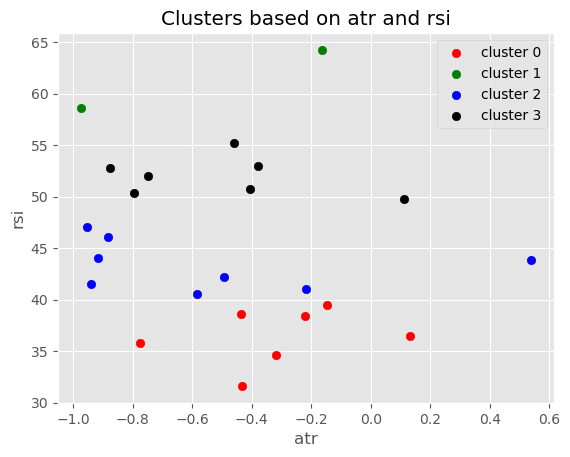

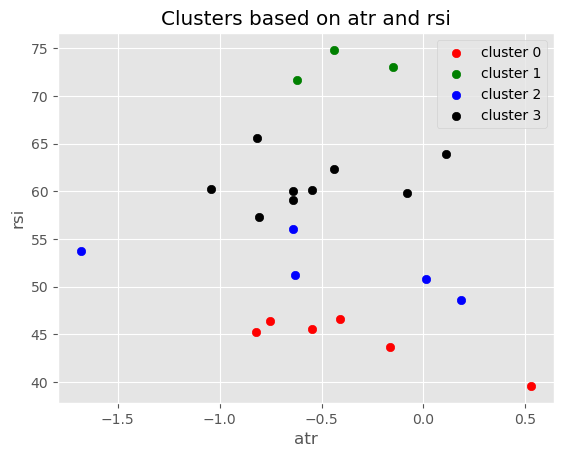

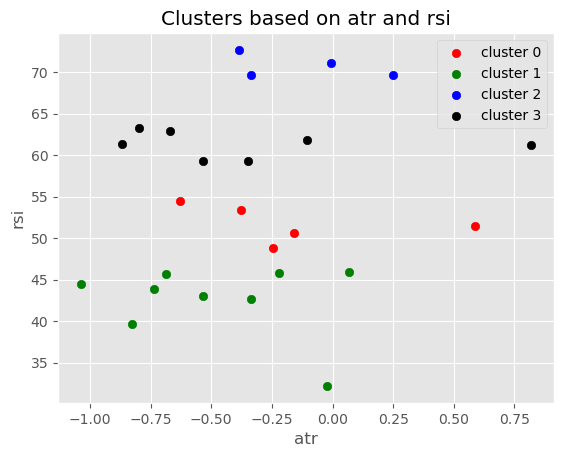

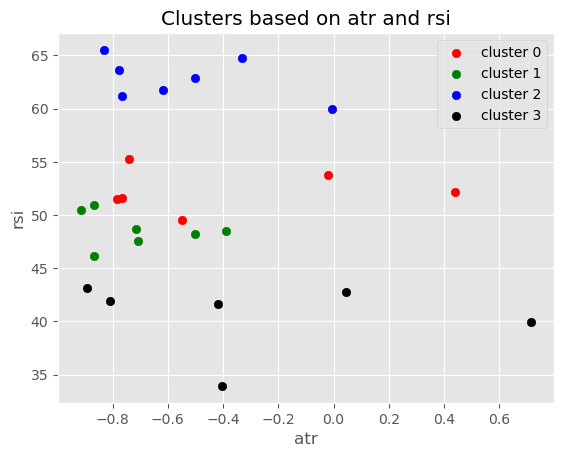

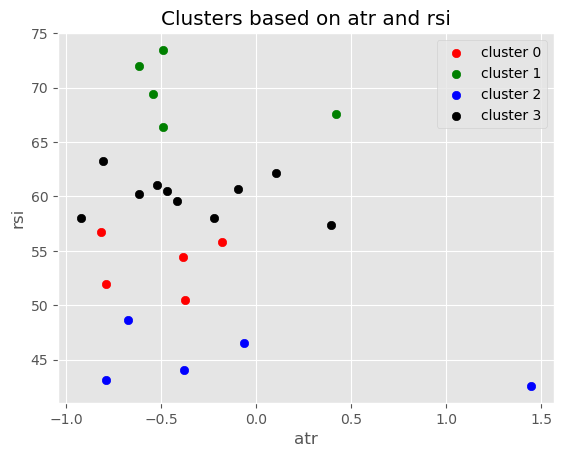

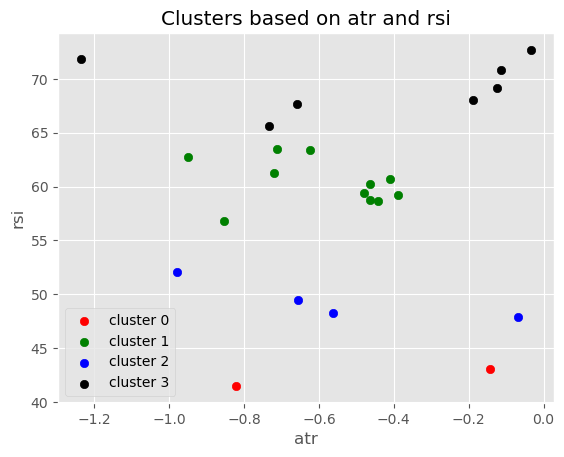

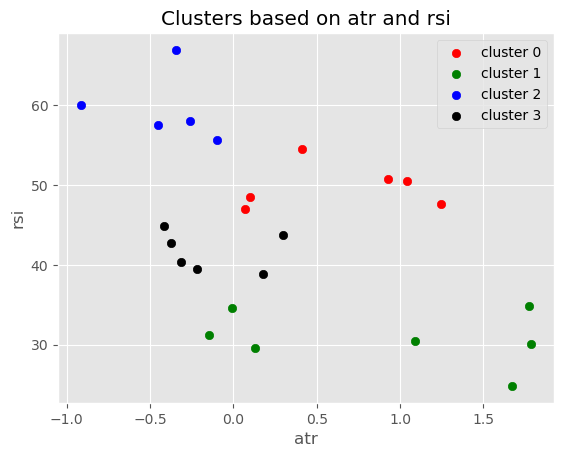

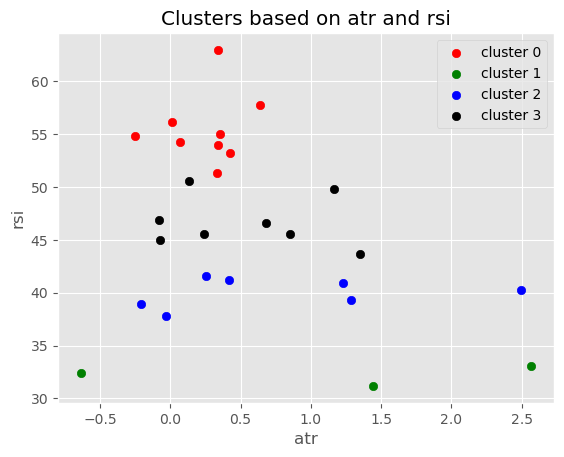

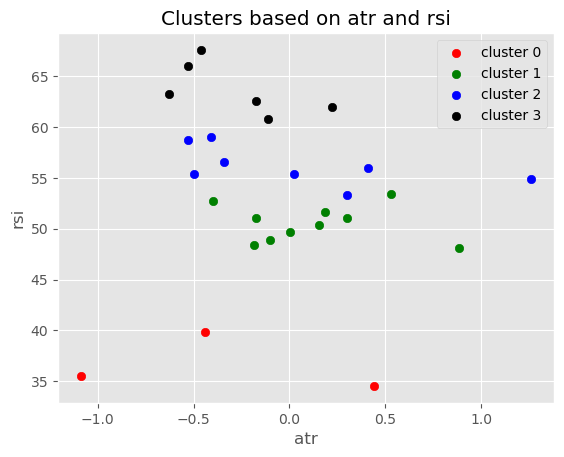

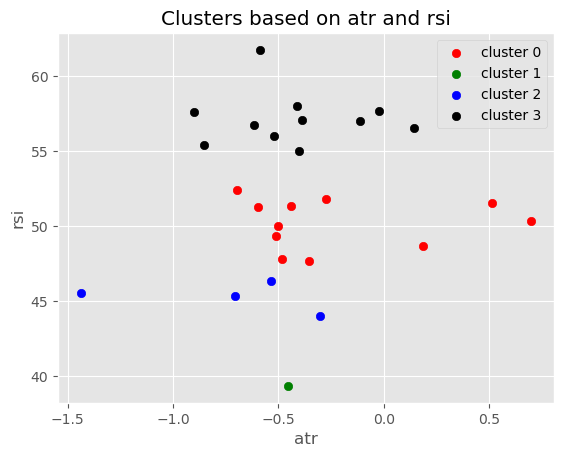

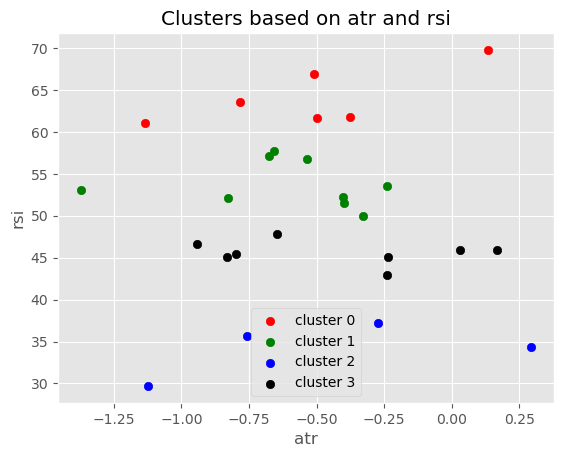

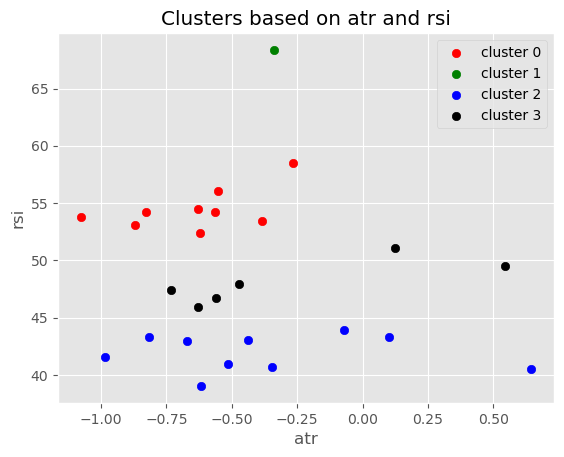

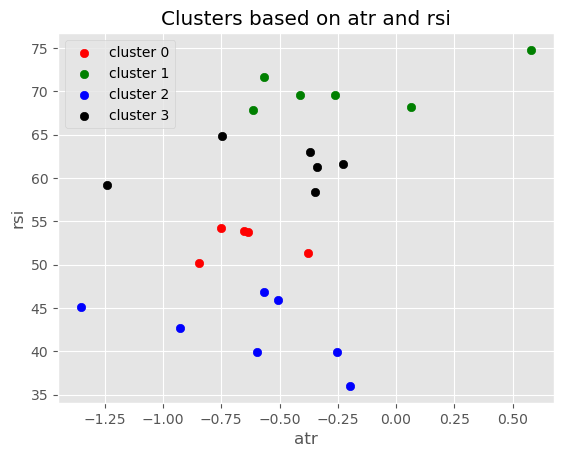

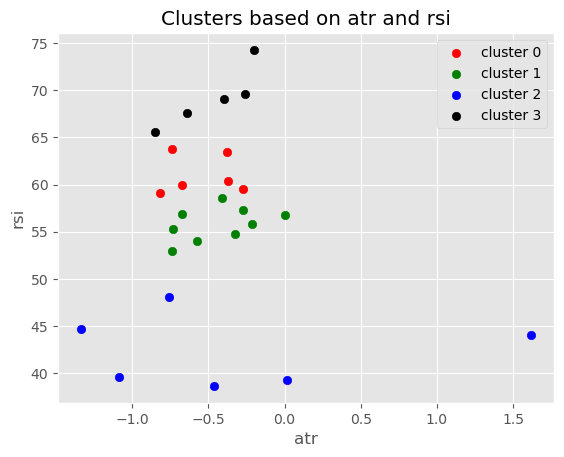

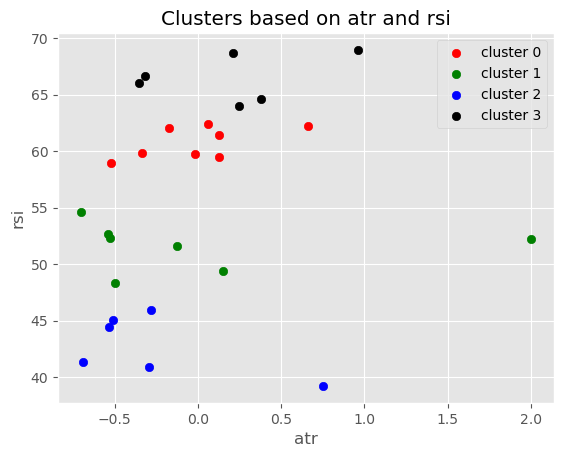

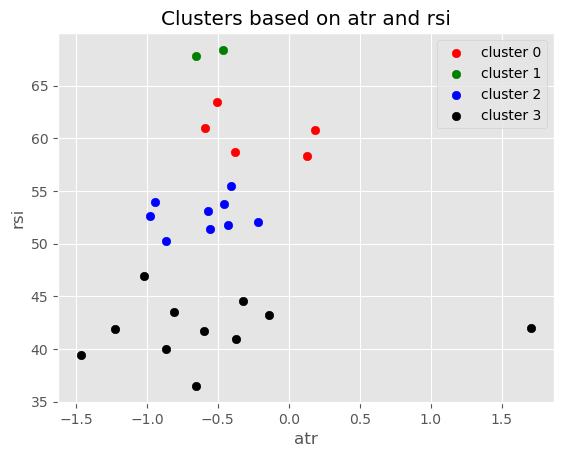

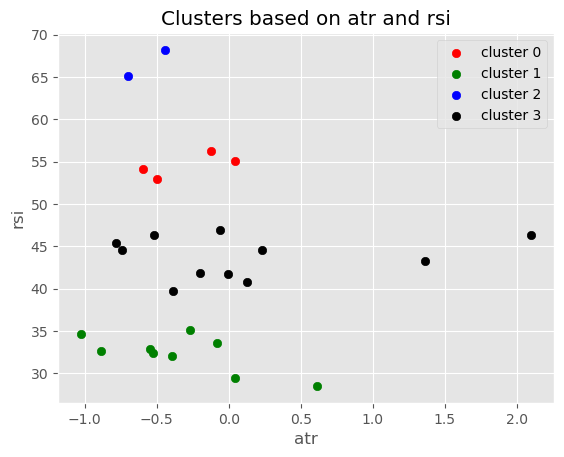

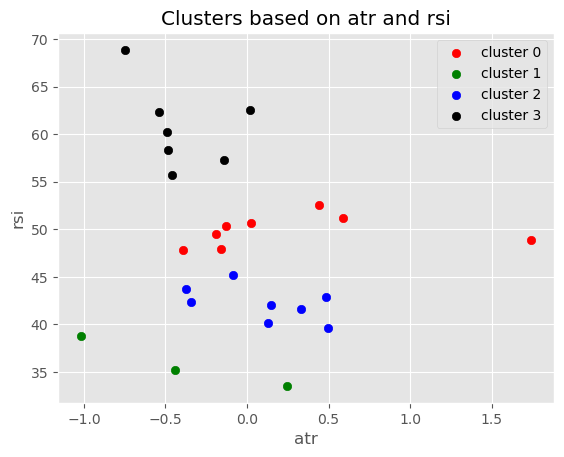

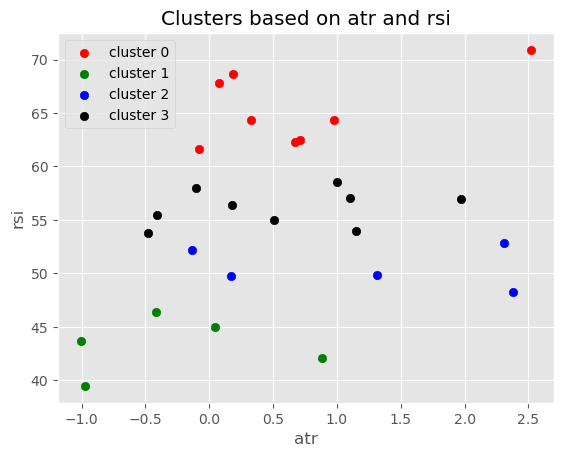

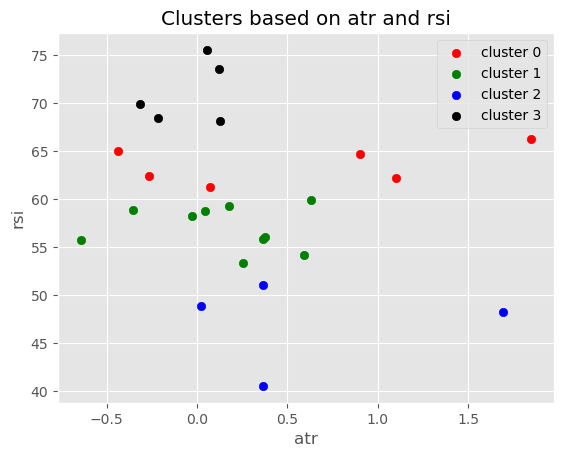

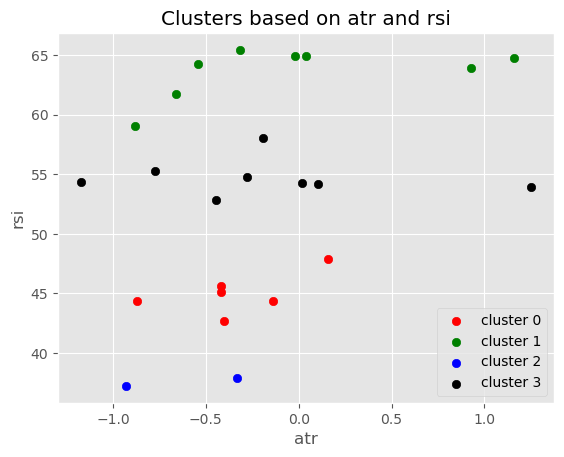

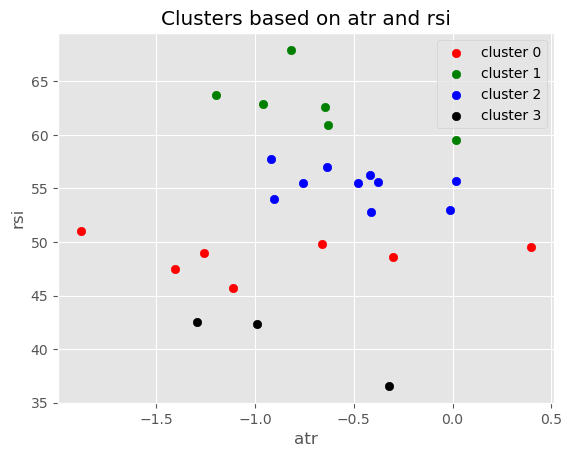

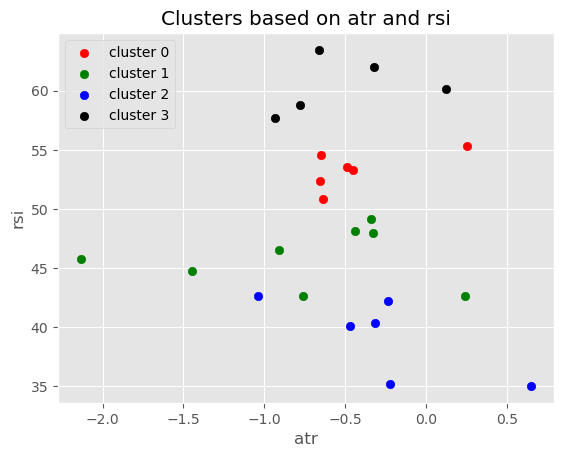

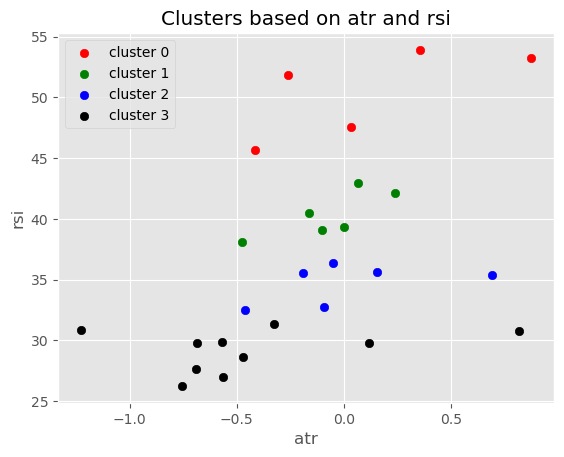

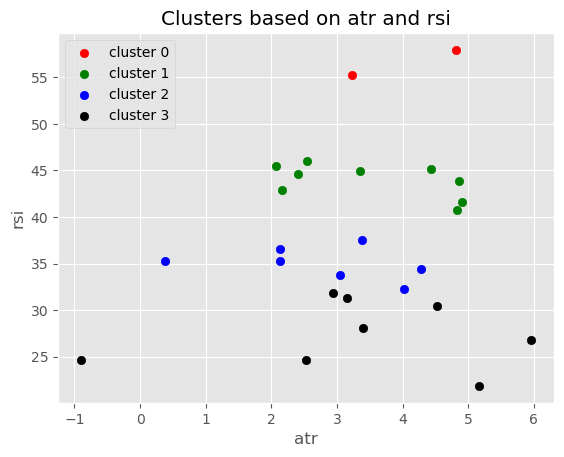

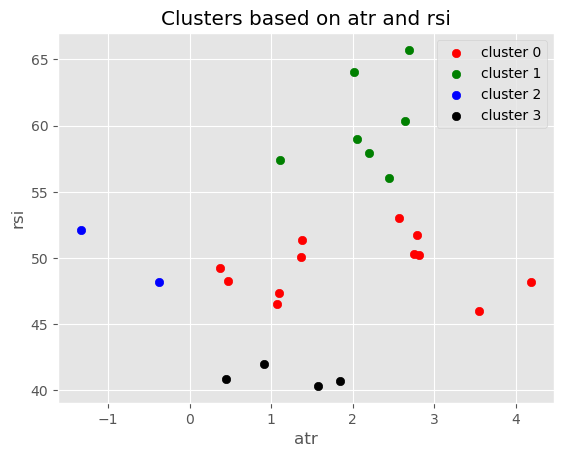

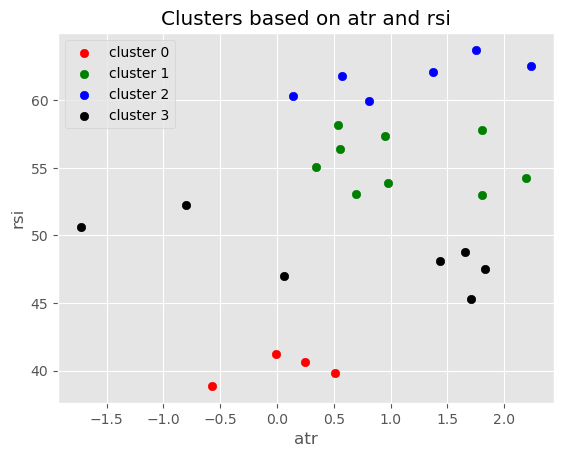

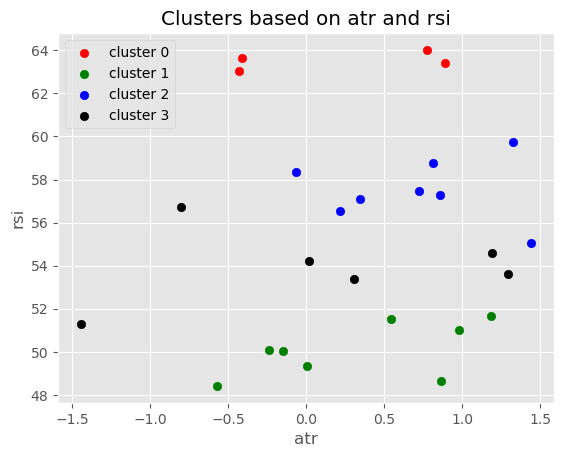

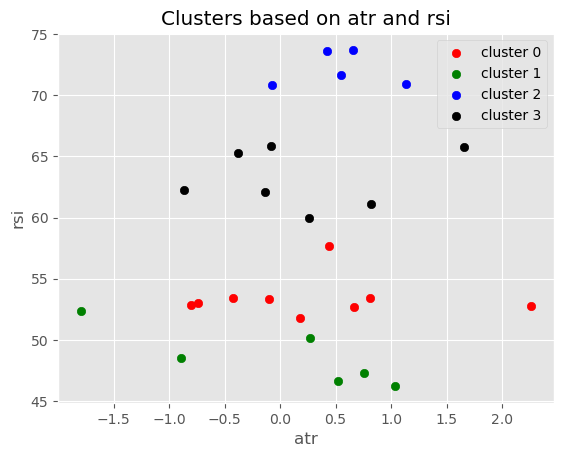

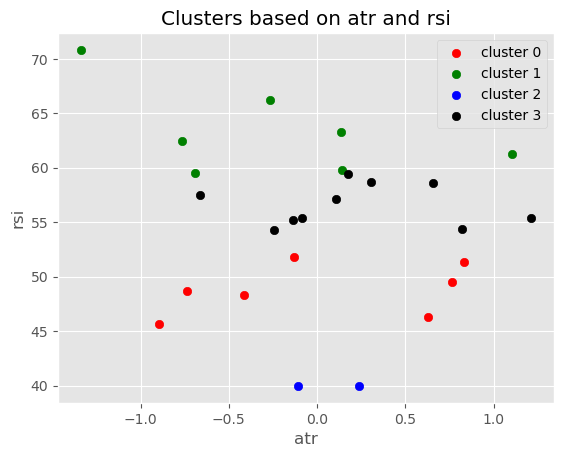

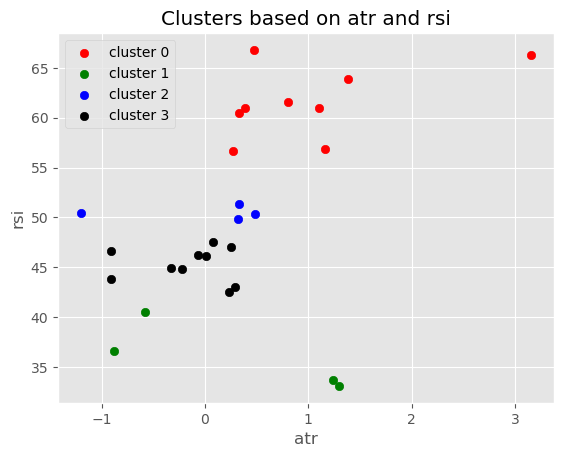

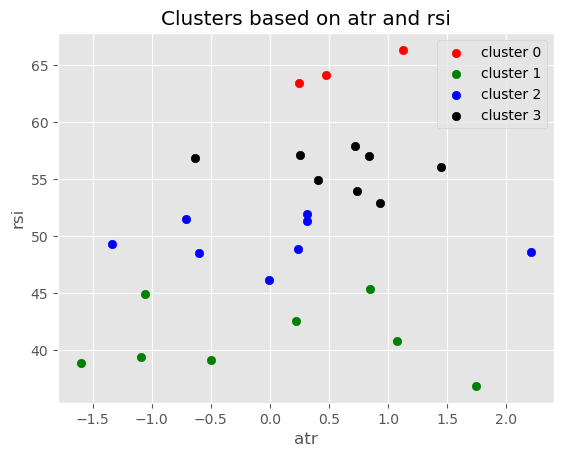

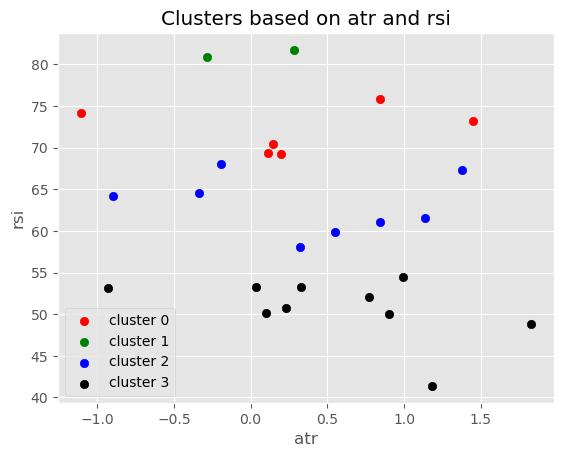

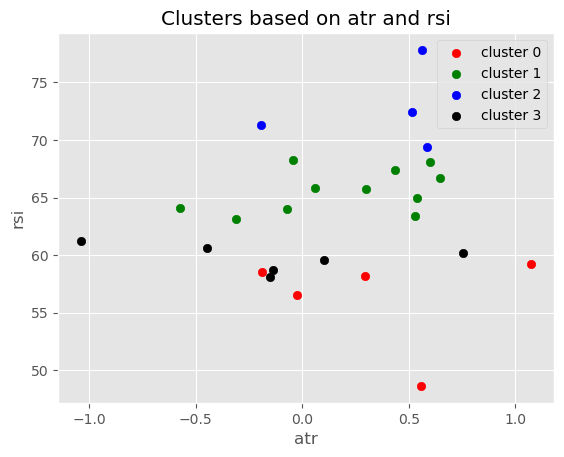

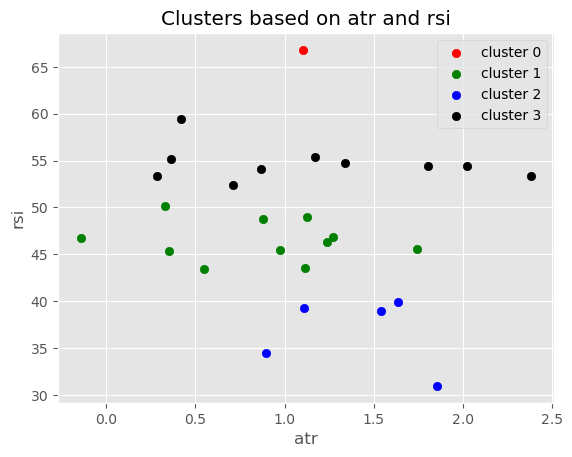

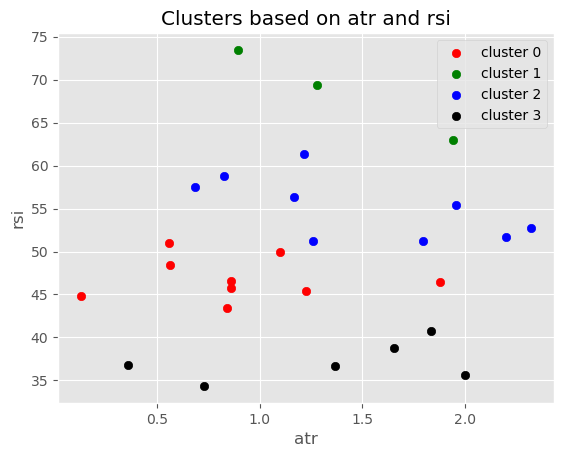

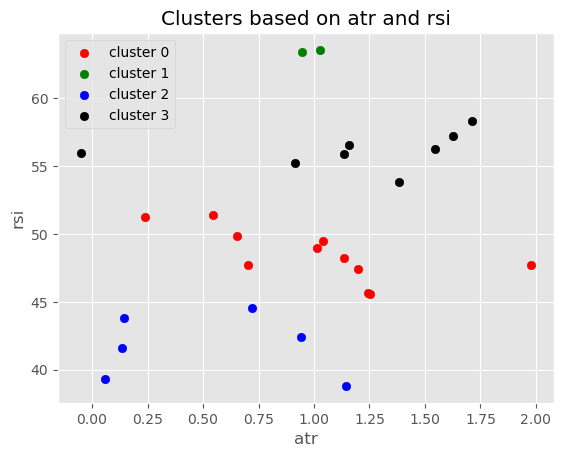

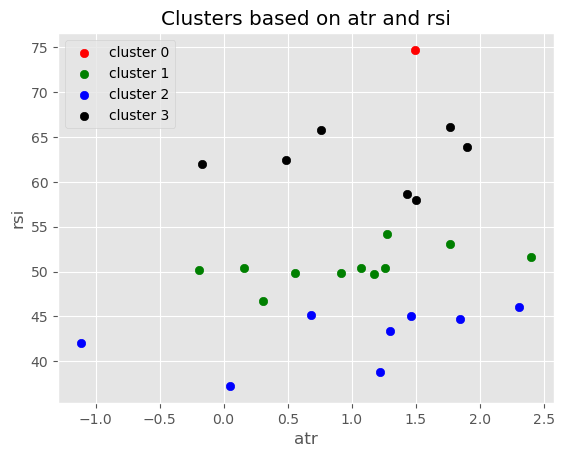

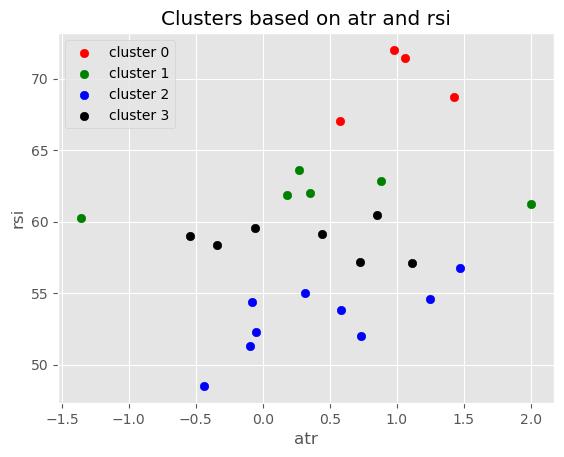

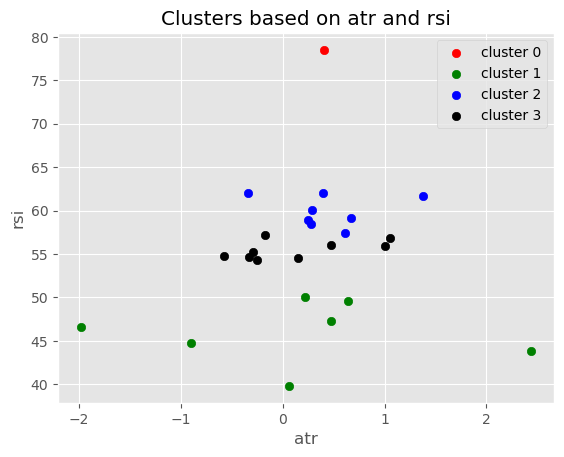

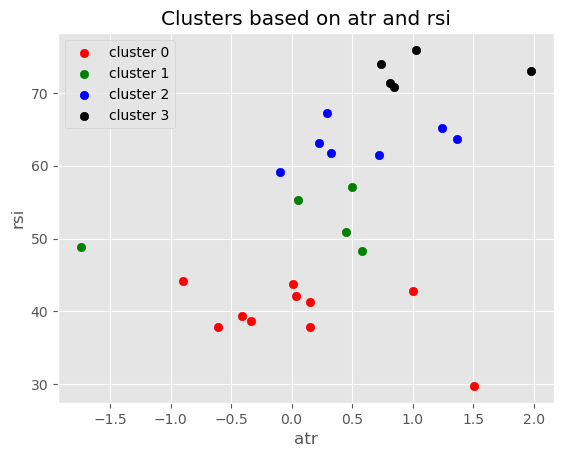

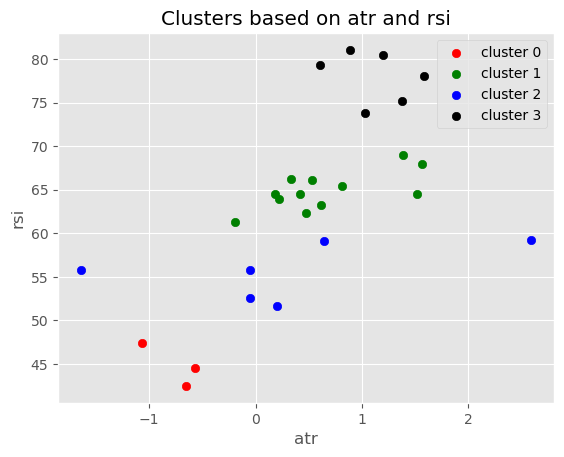

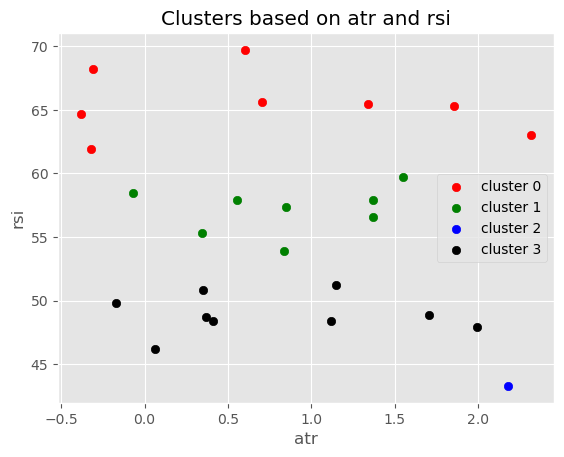

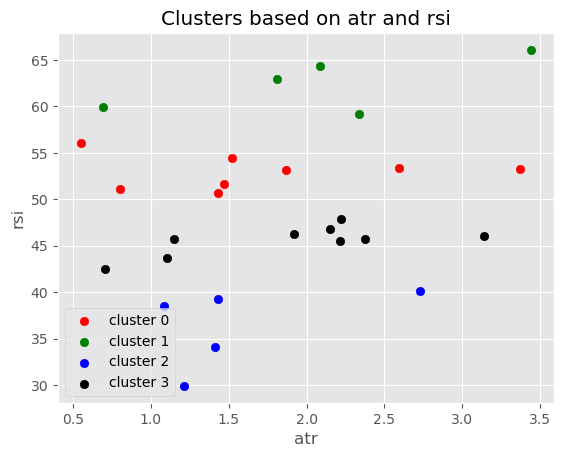

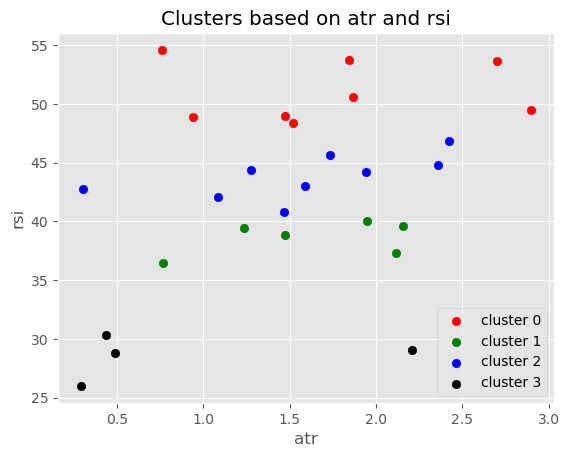

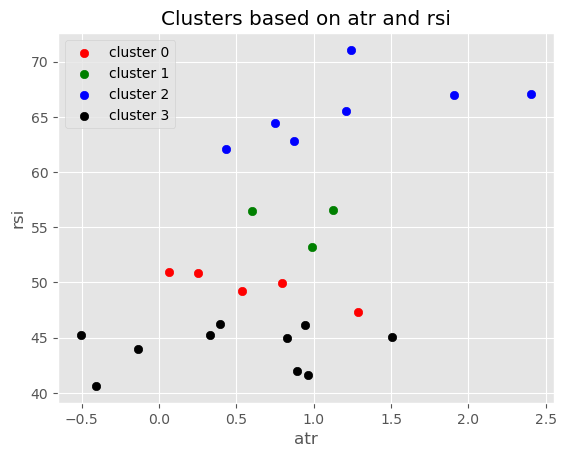

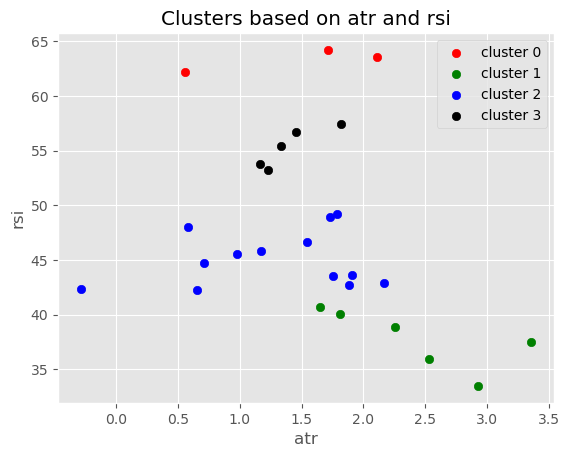

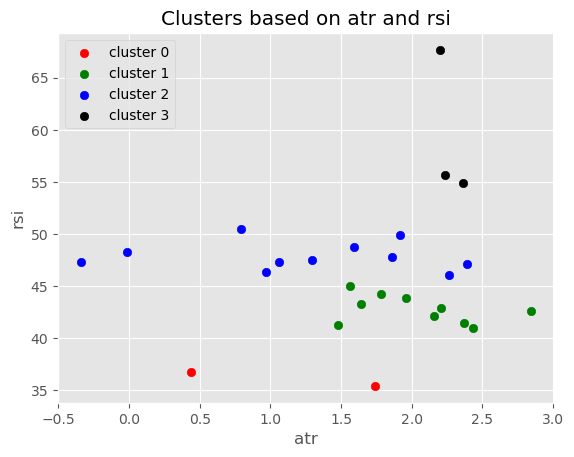

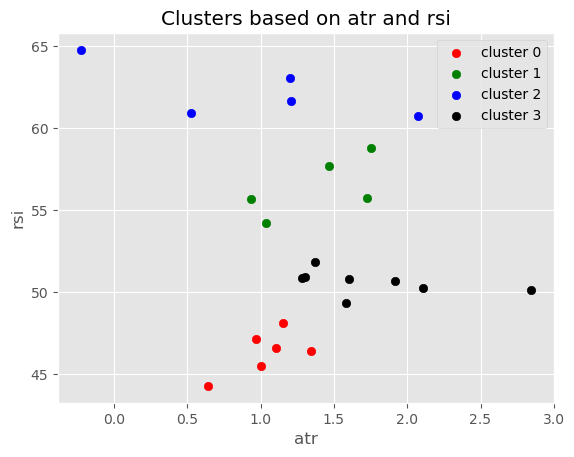

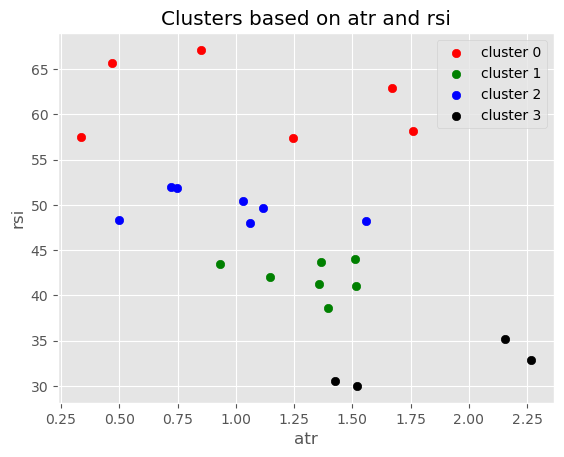

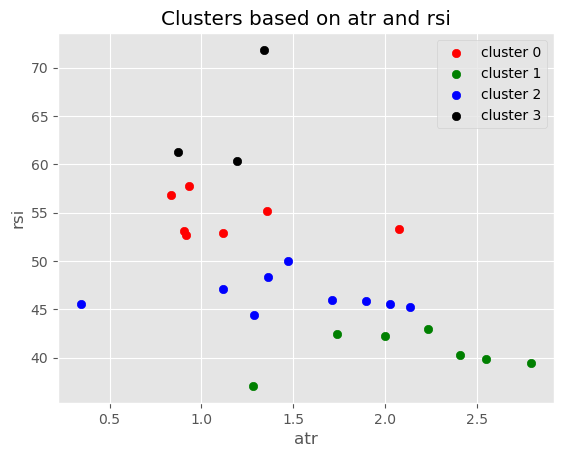

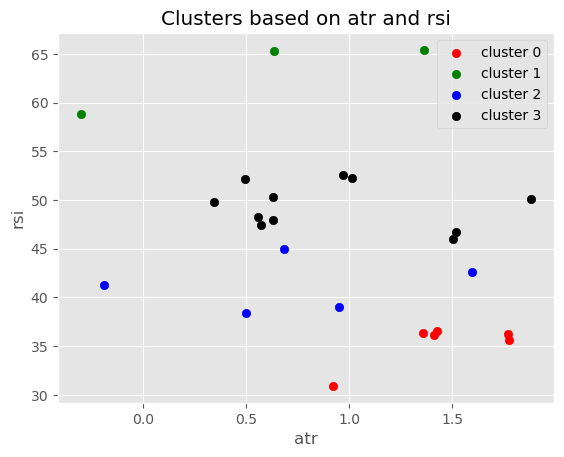

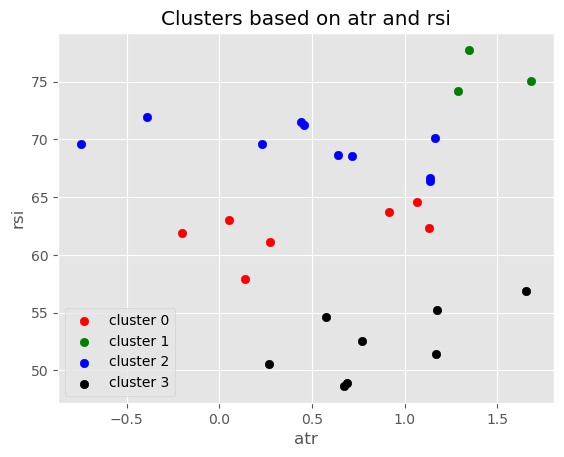

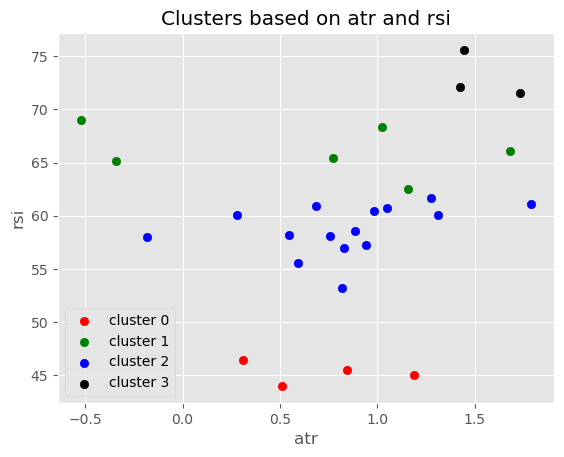

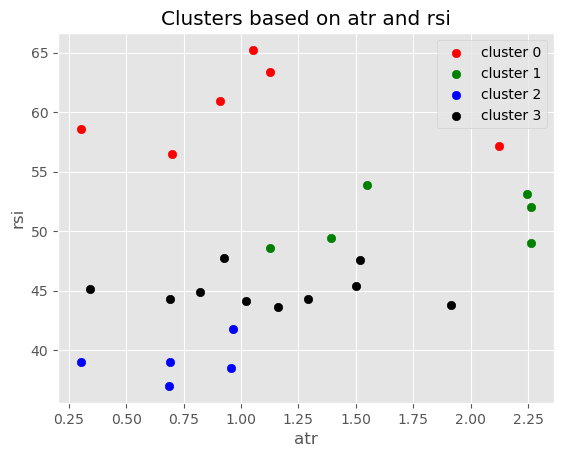

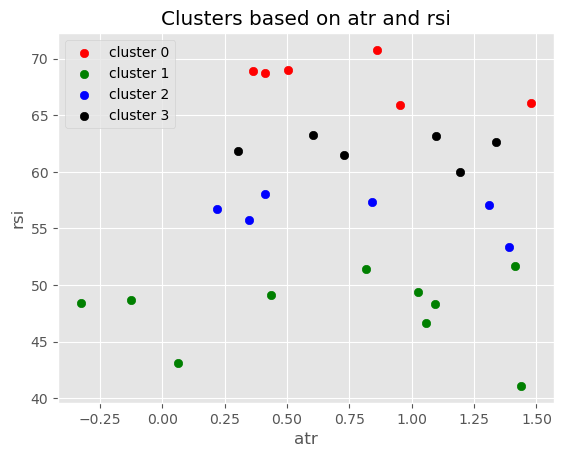

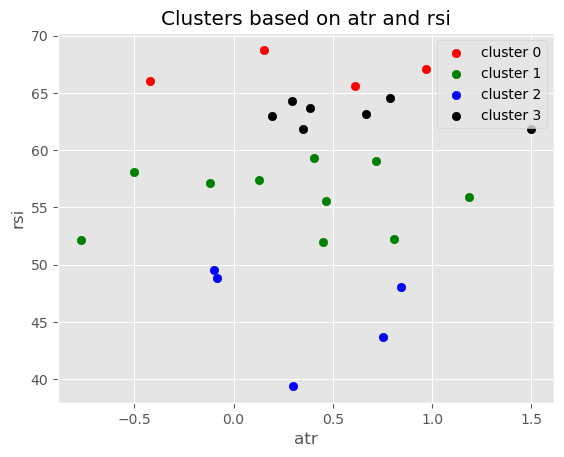

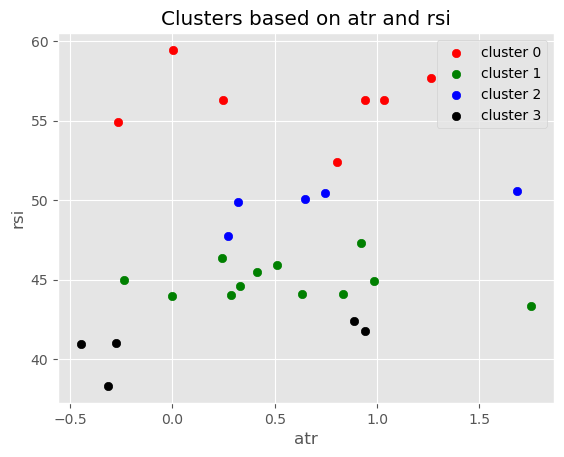

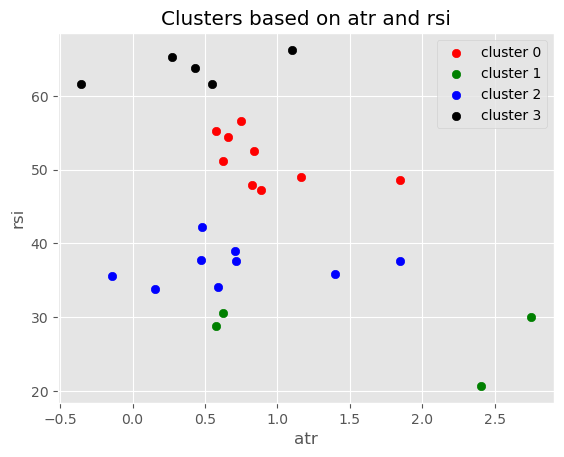

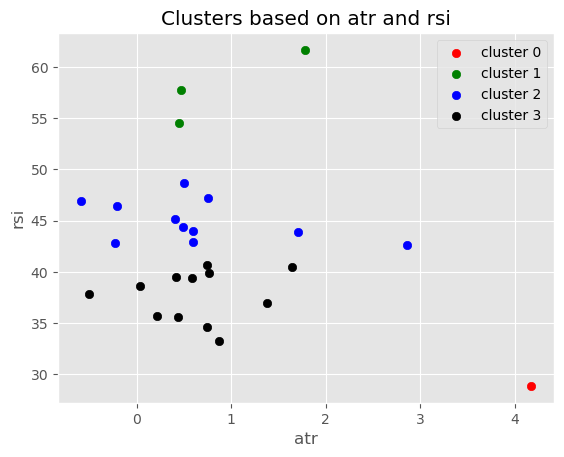

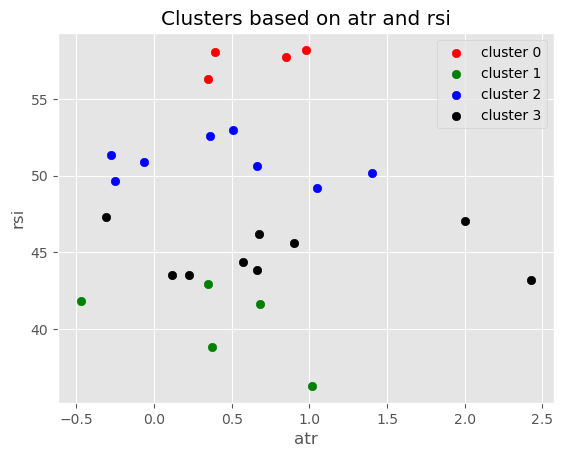

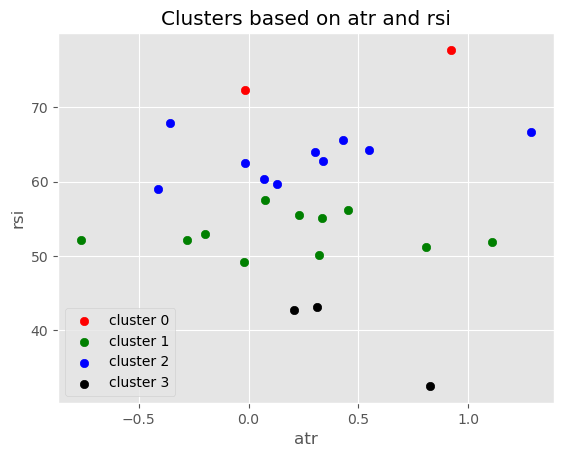

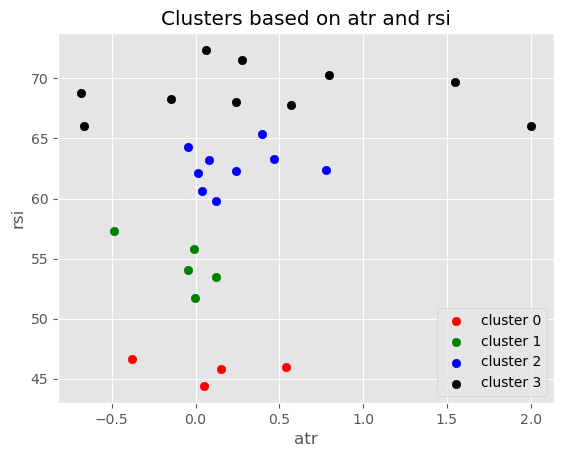

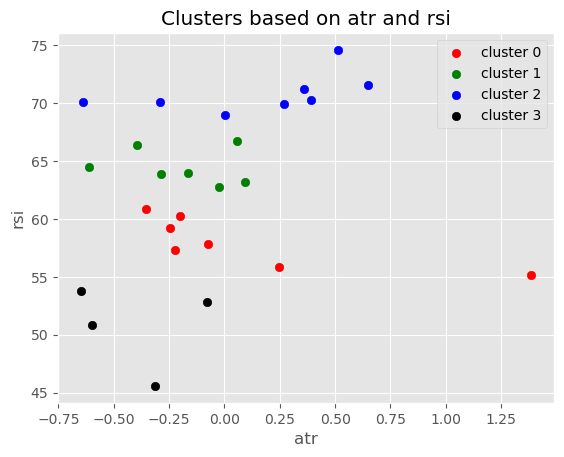

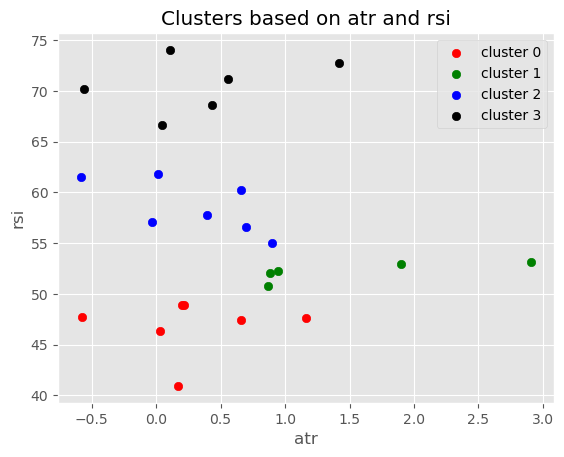

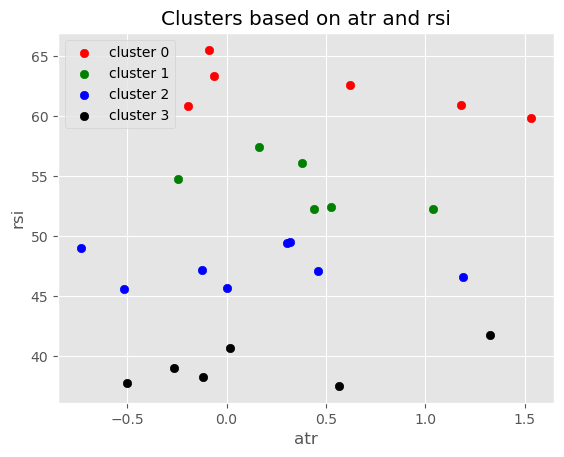

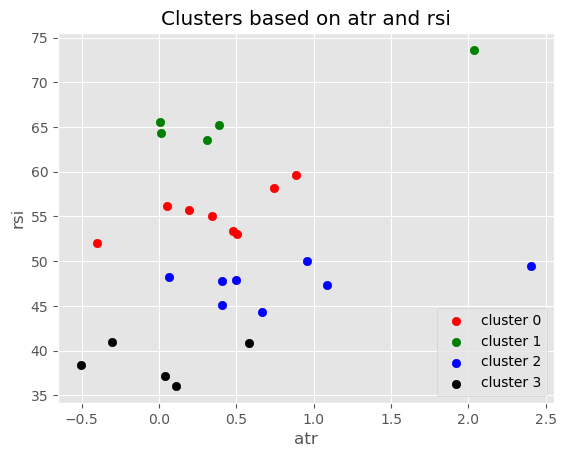

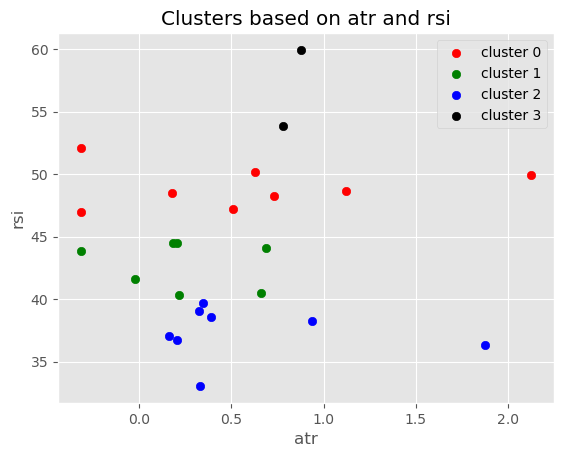

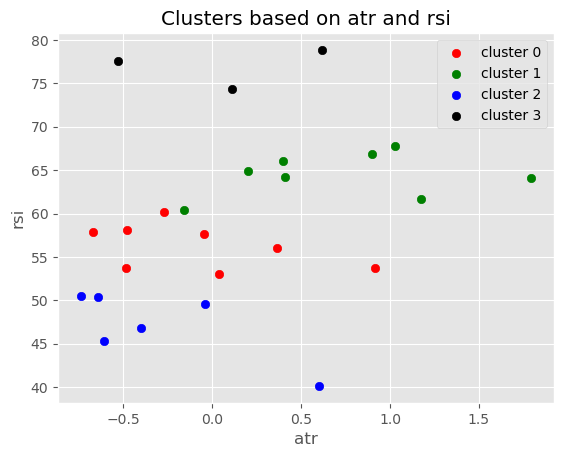

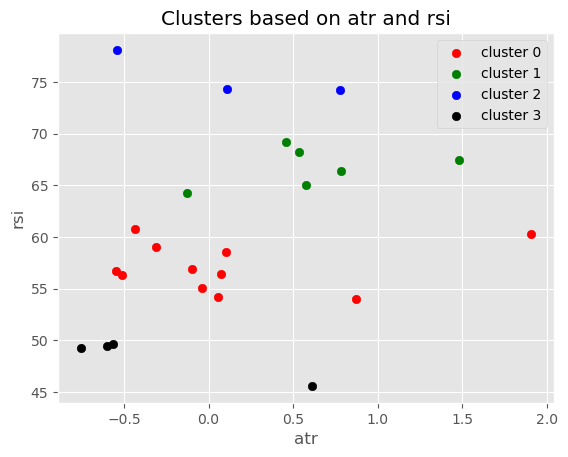

In [14]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

##  Apply pre-defined Centriods

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

In [16]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

data

garman_klass_vol        rsi    bb_low    bb_mid  \
date       ticker                                                           
2017-01-31 AXISBANK.NS           -0.000133  50.399413  6.069462  6.126097   
           HCLTECH.NS            -0.013065  45.978354  5.848096  5.875160   
           HDFCBANK.NS           -0.000721  67.618823  6.324470  6.379680   
           ICICIBANK.NS          -0.000131  55.501089  5.398469  5.444866   
           INDUSINDBK.NS         -0.000346  65.374084  6.966738  7.051620   
...                                    ...        ...       ...       ...   
2023-12-31 SBIN.NS                0.000063  49.651621  6.319633  6.349924   
           TATAMOTORS.NS          0.000059  66.415798  6.441771  6.509480   
           TATASTEEL.NS           0.000124  64.267123  4.763704  4.823854   
           TCS.NS                 0.000025  55.050350  8.100732  8.142842   
           ULTRACEMCO.NS          0.000200  65.031669  9.041387  9.071900   

                           bb_high       atr      macd  return_1m  return_2m  \
date       ticker                                                              
2017-01-31 AXISBANK.NS    6.182732 -0.967470 -0.003962   0.035671  -0.004105   
           HCLTECH.NS     5.902224 -0.842420 -0.111814  -0.020291   0.004562   
           HDFCBANK.NS    6.434890 -1.250169  0.417313   0.066697   0.035648   
           ICICIBANK.NS   5.491263 -1.257621 -0.057290   0.053467   0.006381   
           INDUSINDBK.NS  7.136502 -0.784013  1.036671   0.130111   0.073411   
...                            ...       ...       ...        ...        ...   
2023-12-31 SBIN.NS        6.380216 -0.564026 -0.500292   0.012395   0.005466   
           TATAMOTORS.NS  6.577189  0.780871  1.497857  -0.001345   0.059324   
           TATASTEEL.NS   4.884004 -0.129775  0.657972   0.016419   0.046297   
           TCS.NS         8.184952 -0.036509  0.266453   0.006896   0.020989   
           ULTRACEMCO.NS  9.102412  0.575865  1.069551   0.072617   0.046121   

                          return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                       
2017-01-31 AXISBANK.NS    -0.014518  -0.026105  -0.000481    0.011840   
           HCLTECH.NS      0.020541   0.015019   0.011301   -0.003492   
           HDFCBANK.NS     0.007254   0.005338   0.015217    0.017787   
           ICICIBANK.NS   -0.009604   0.003799   0.016473    0.014789   
           INDUSINDBK.NS   0.014311   0.010549   0.020340    0.025552   
...                             ...        ...        ...         ...   
2023-12-31 SBIN.NS        -0.015153  -0.000320   0.011952   -0.004287   
           TATAMOTORS.NS   0.038315   0.029161   0.059455    0.051365   
           TATASTEEL.NS    0.002837   0.025150   0.028220    0.014721   
           TCS.NS         -0.000743   0.011172   0.011587    0.009042   
           ULTRACEMCO.NS   0.030426   0.037862   0.034033    0.041435   

                            Mkt-RF       SMB       HML       RMW       CMA  \
date       ticker                                                            
2017-01-31 AXISBANK.NS    0.863364  0.232647  0.373941 -0.420440  0.057822   
           HCLTECH.NS     0.967453 -0.644320  0.205449 -0.280619  0.060663   
           HDFCBANK.NS    0.457319  0.378685  0.139145 -0.030581  0.215997   
           ICICIBANK.NS   0.737378 -0.675218  0.798534 -0.306121 -0.440757   
           INDUSINDBK.NS  1.054514  0.305098  0.374737 -0.998176 -0.013994   
...                            ...       ...       ...       ...       ...   
2023-12-31 SBIN.NS        0.563377 -0.350393  0.950826 -0.764198 -0.420912   
           TATAMOTORS.NS  1.252771  0.518702  0.912426  0.746826 -0.615039   
           TATASTEEL.NS   1.119001 -0.262106  0.679456 -0.213079 -0.682841   
           TCS.NS         0.480291 -0.070394 -0.156244 -0.327033  0.149681   
           ULTRACEMCO.NS  0.452557  0.544326  0.647770  1.287276 -1.392334   

                  

In [17]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')

    plt.legend()
    plt.show()
    return

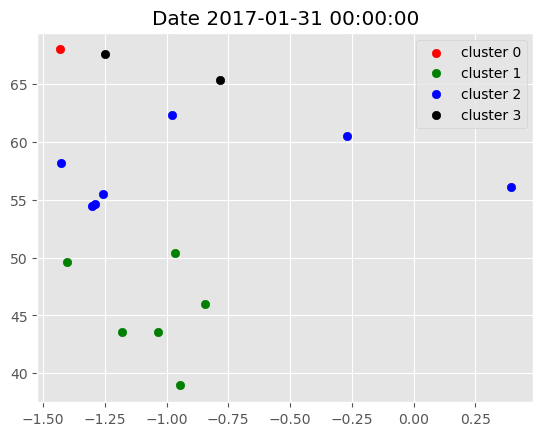

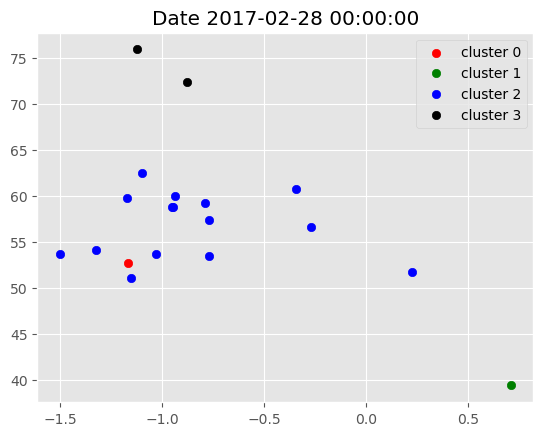

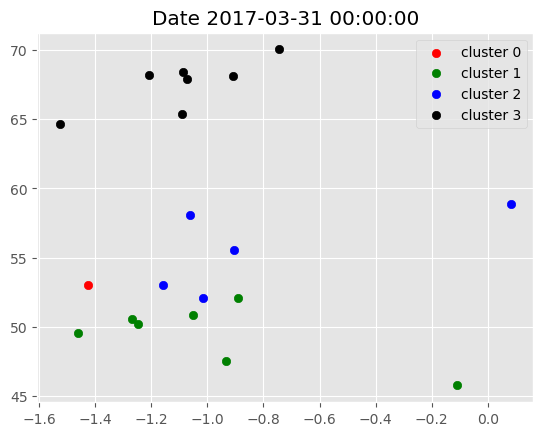

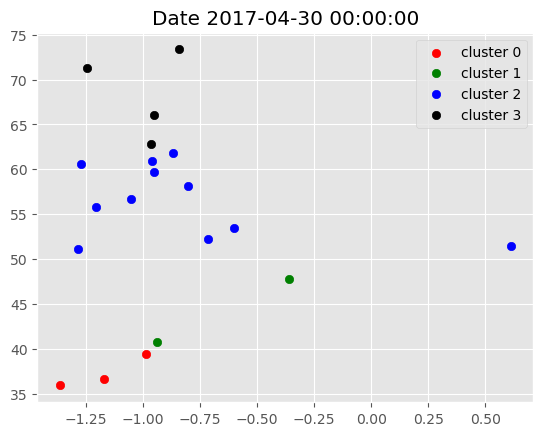

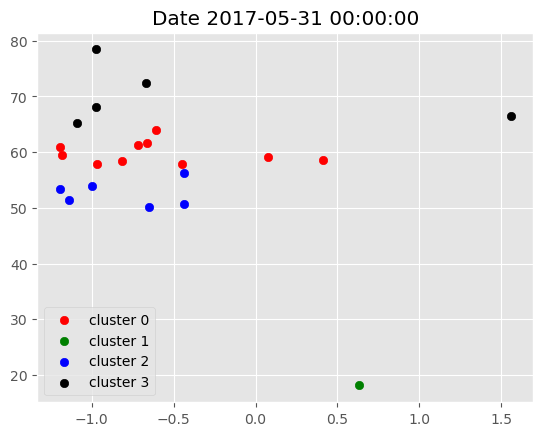

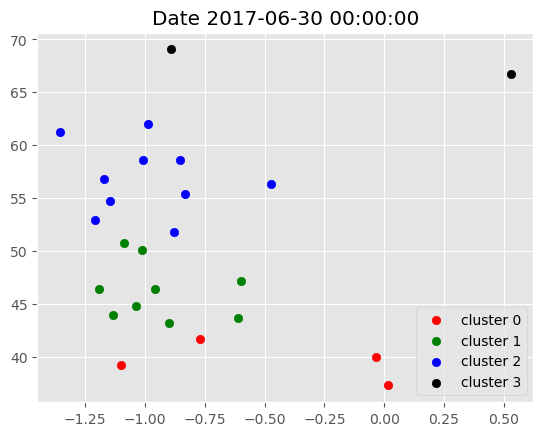

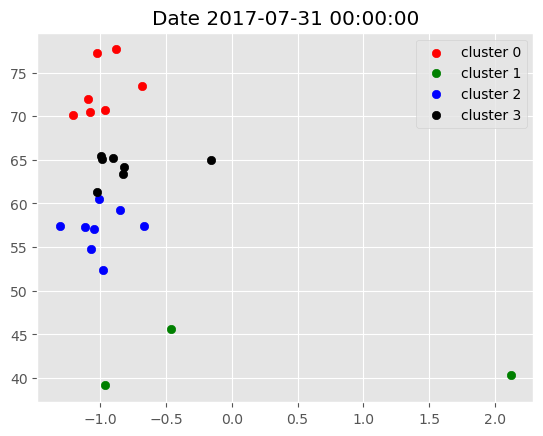

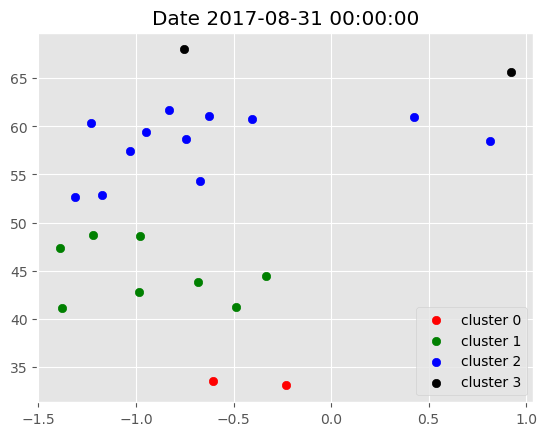

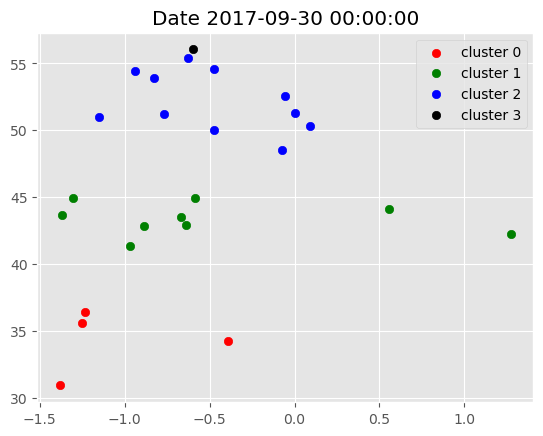

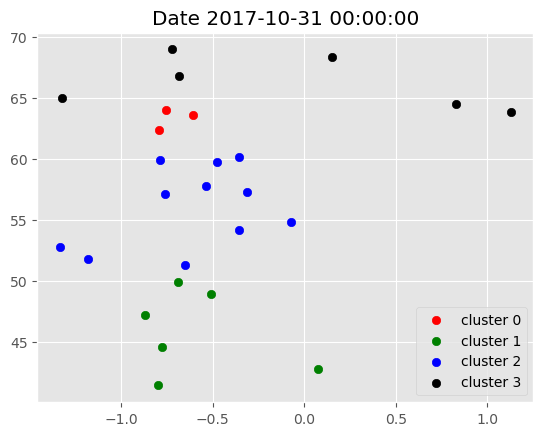

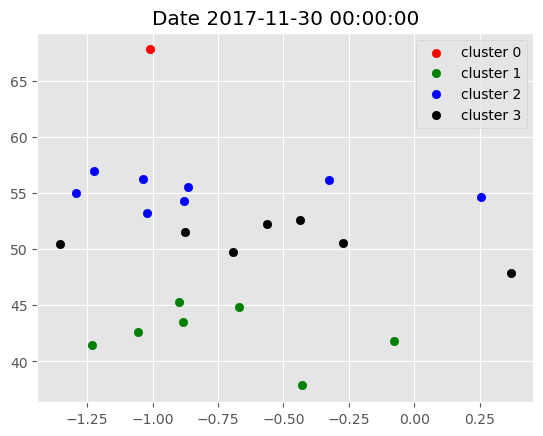

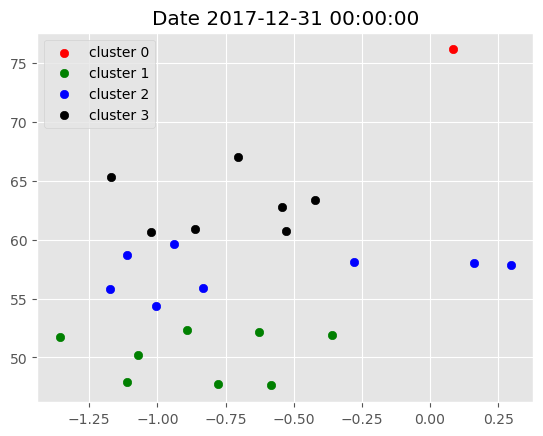

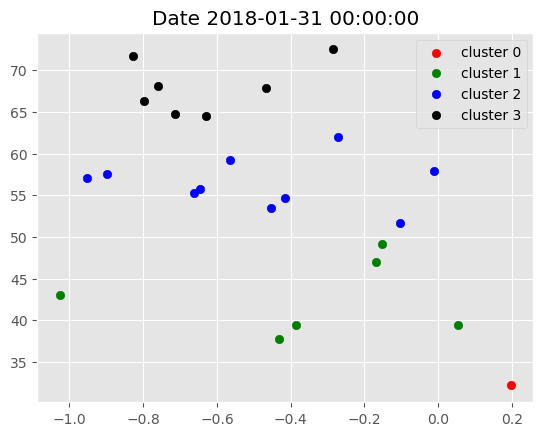

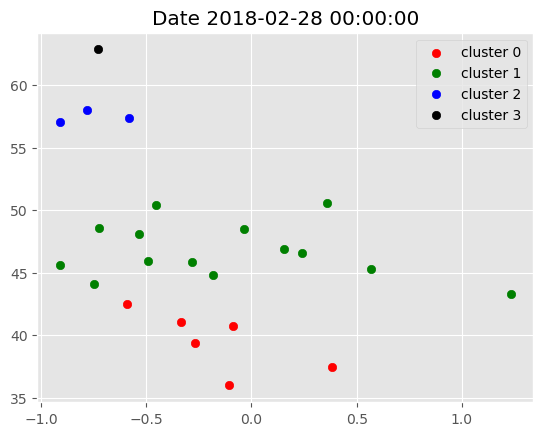

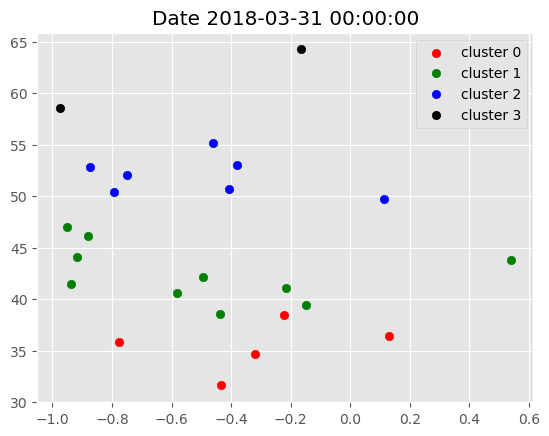

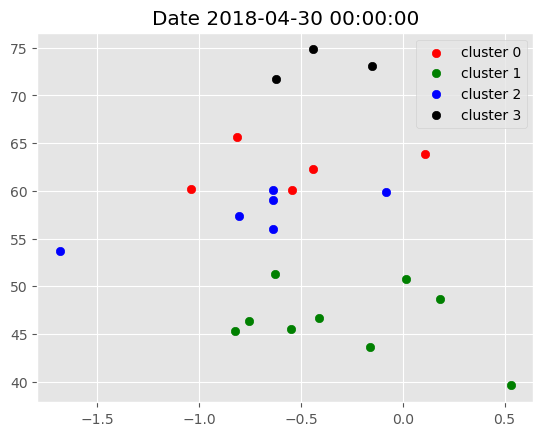

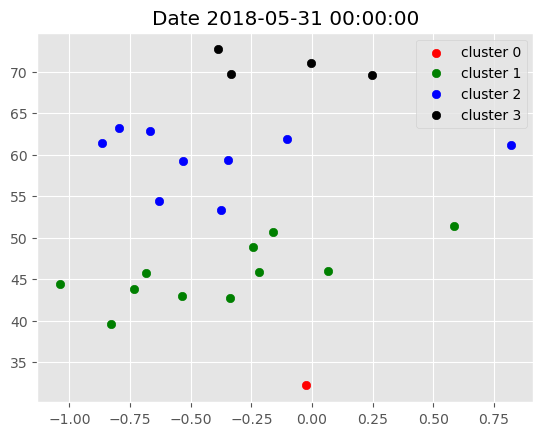

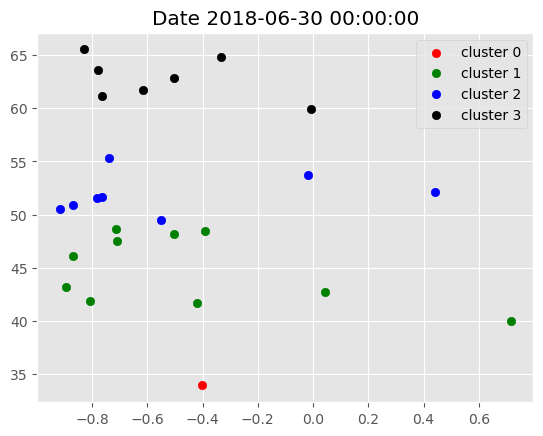

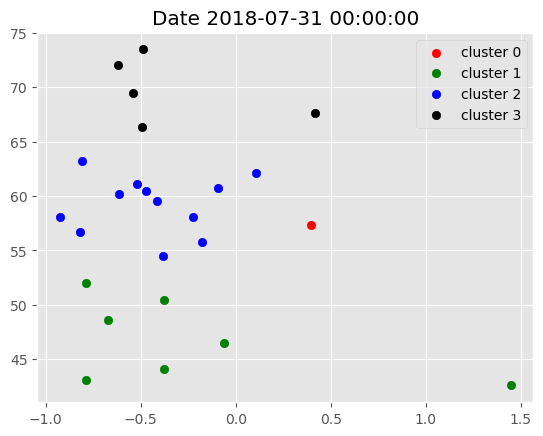

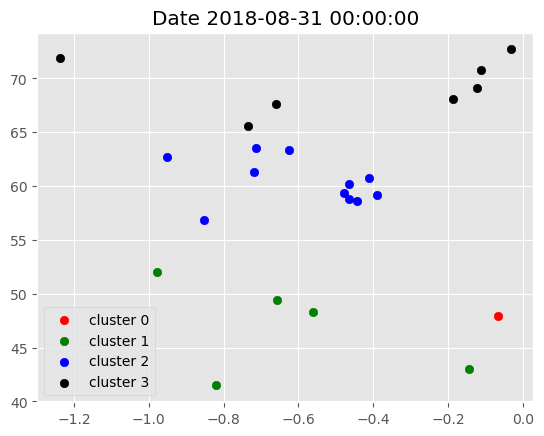

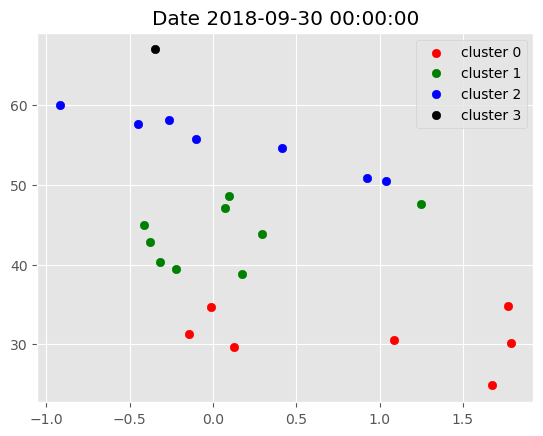

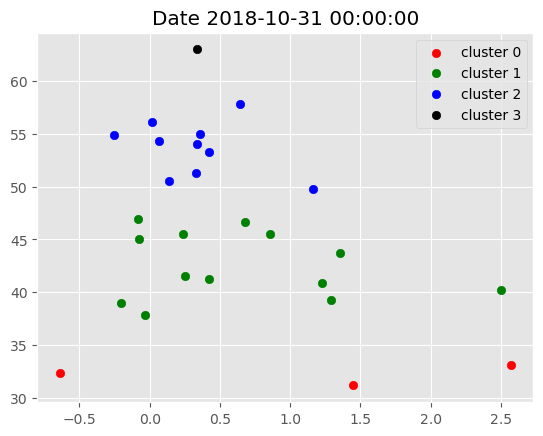

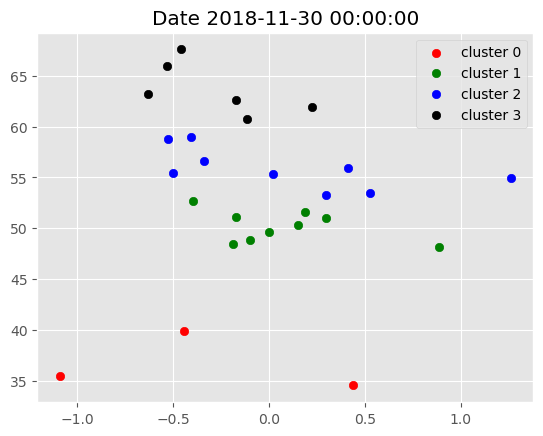

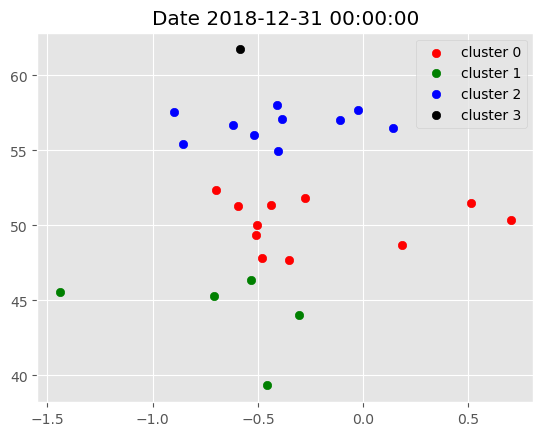

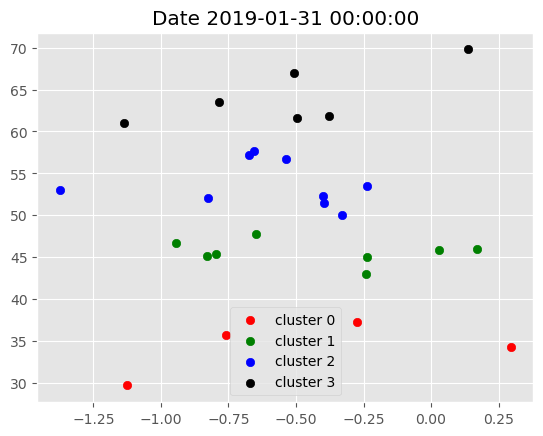

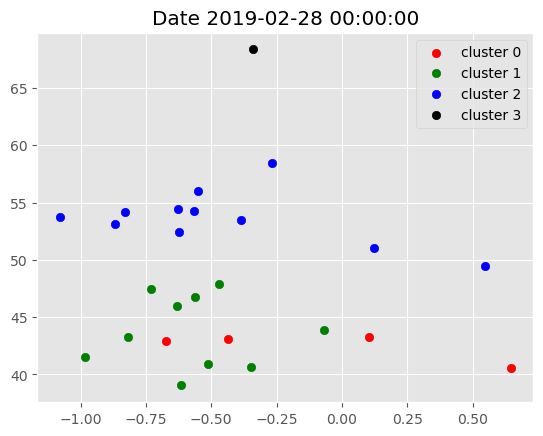

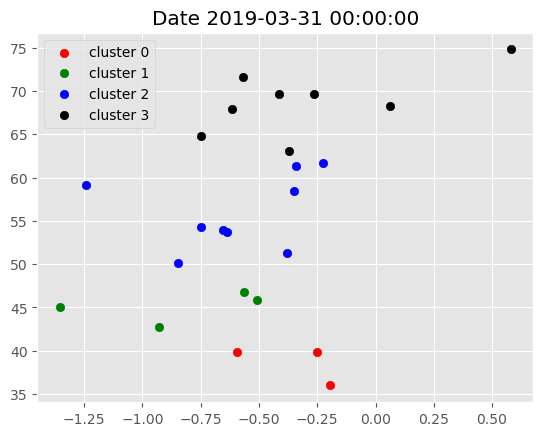

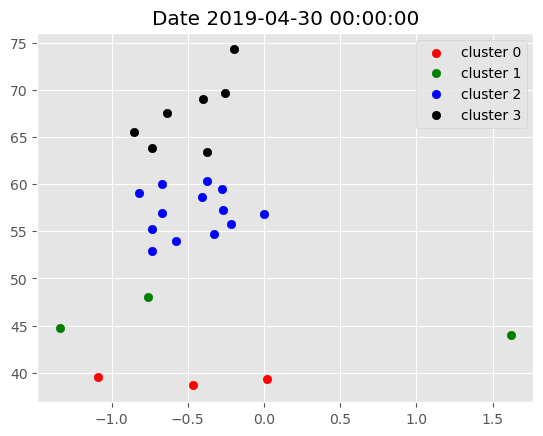

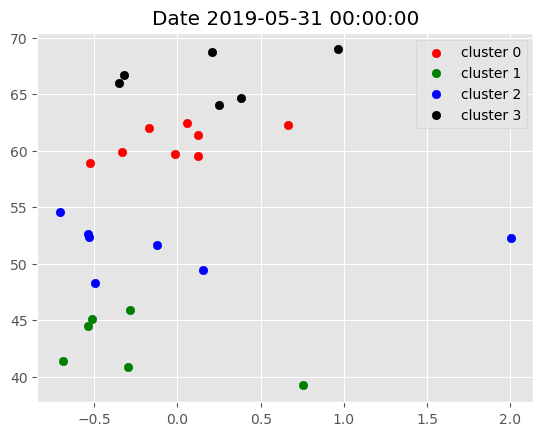

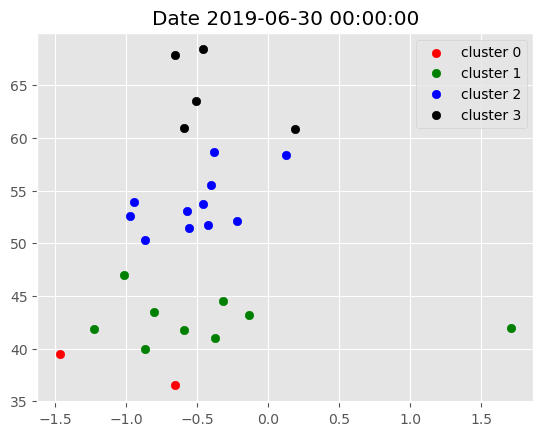

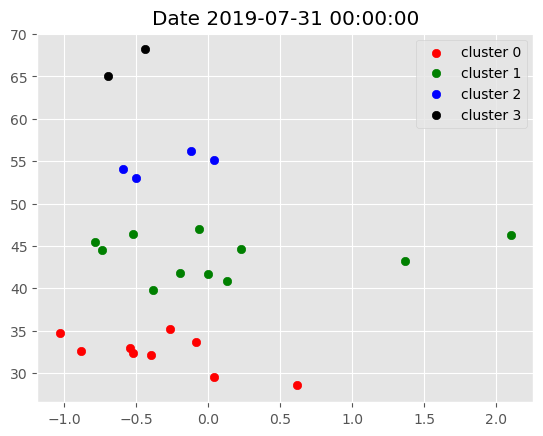

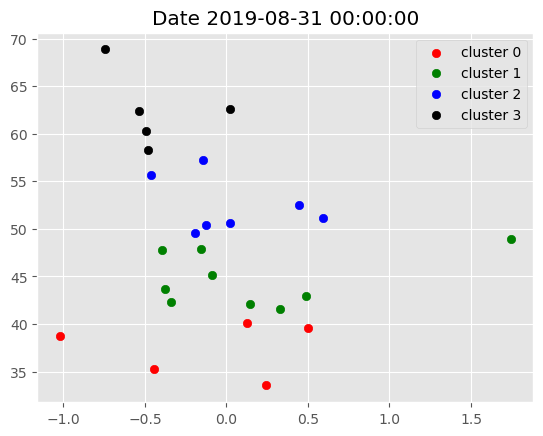

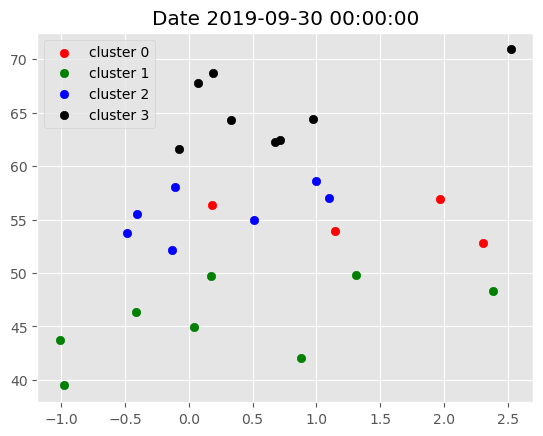

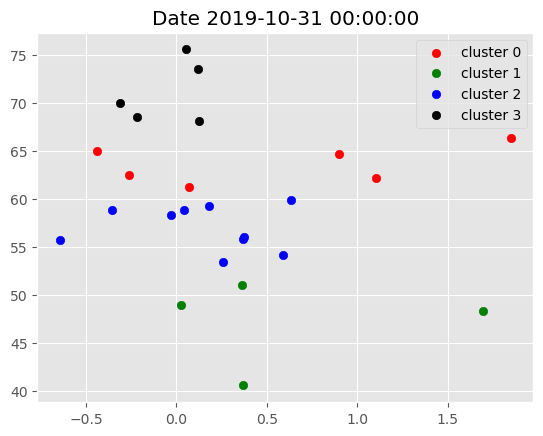

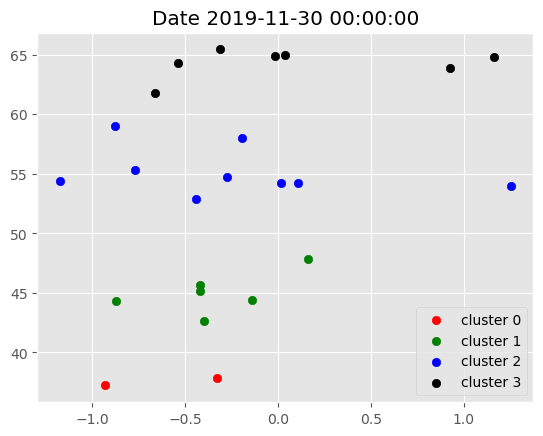

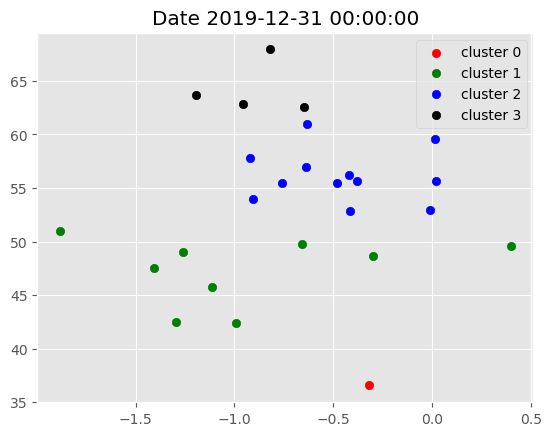

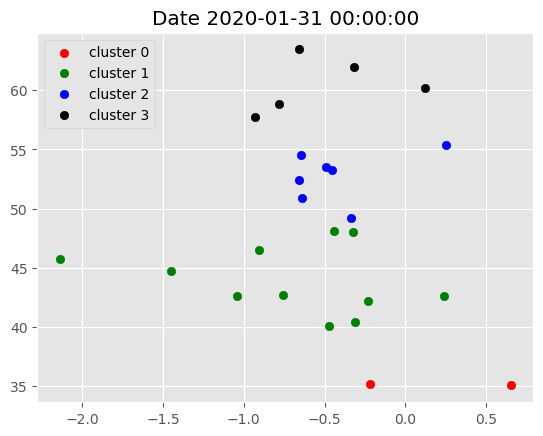

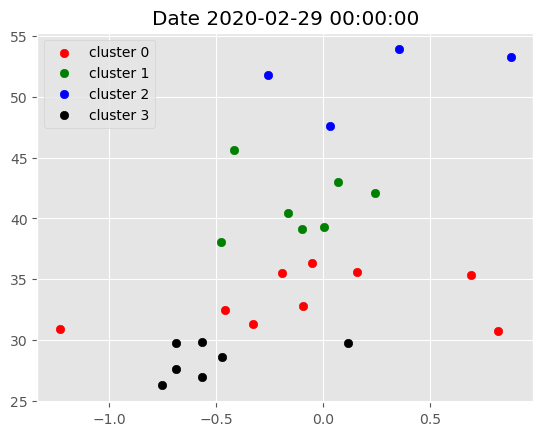

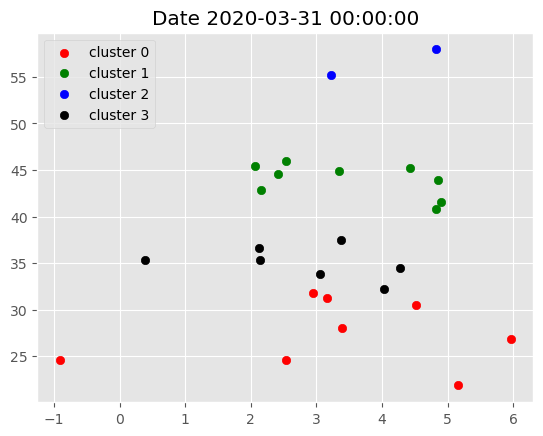

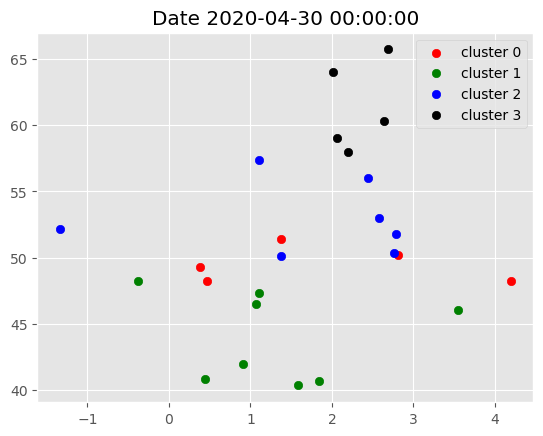

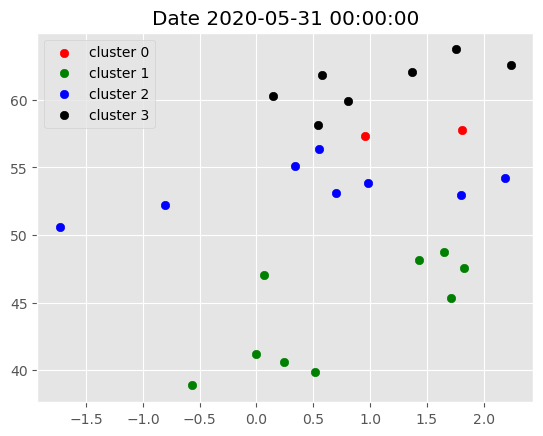

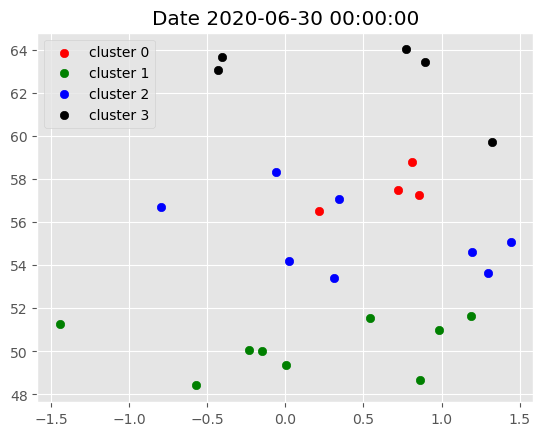

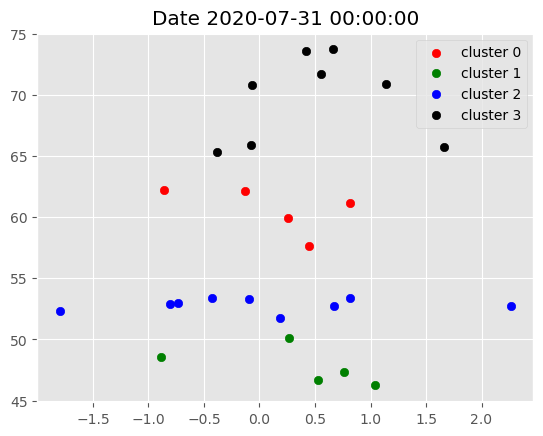

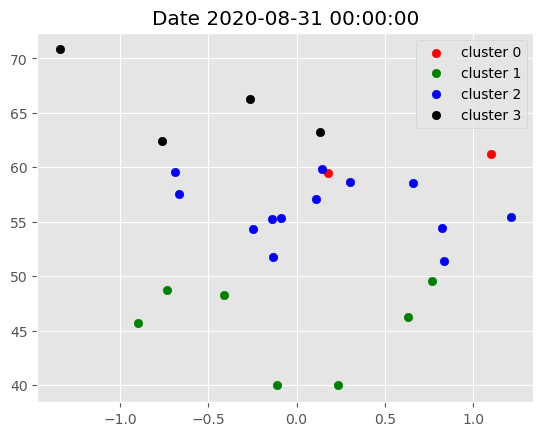

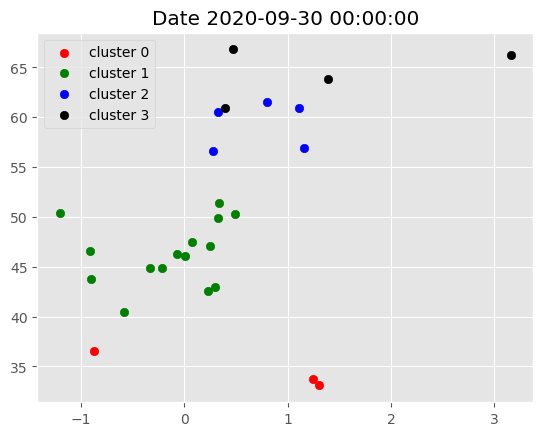

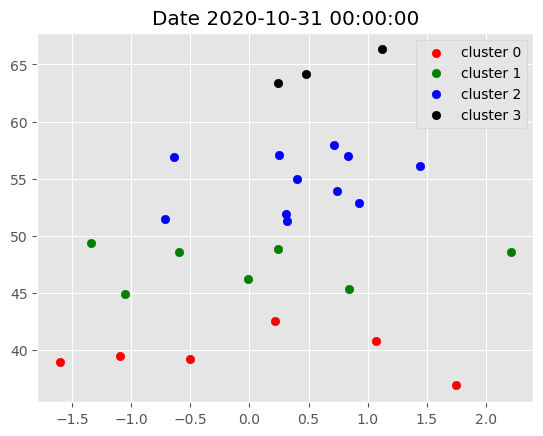

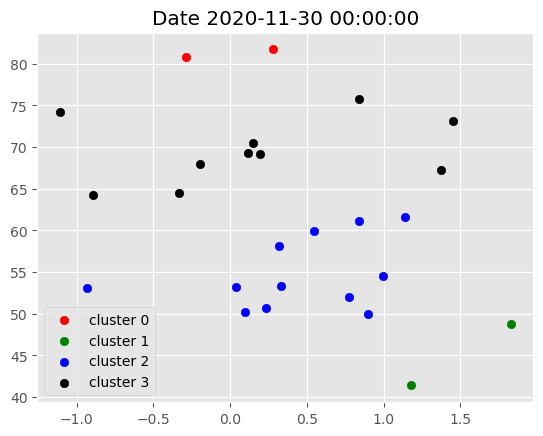

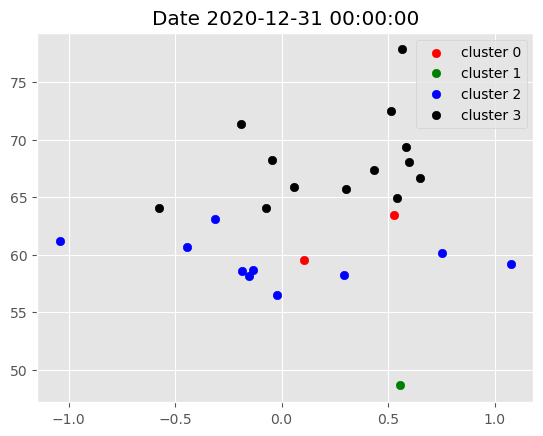

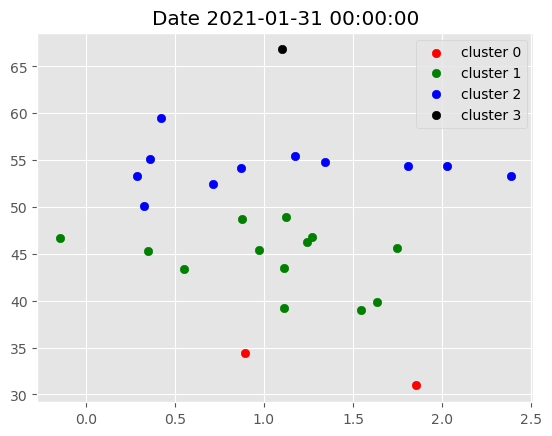

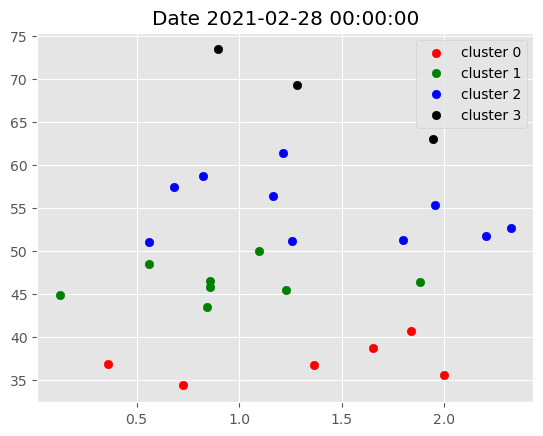

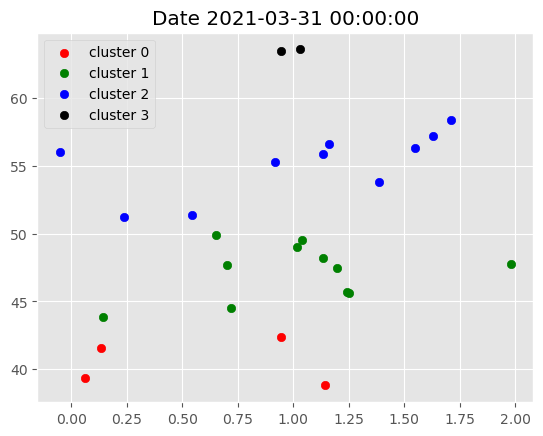

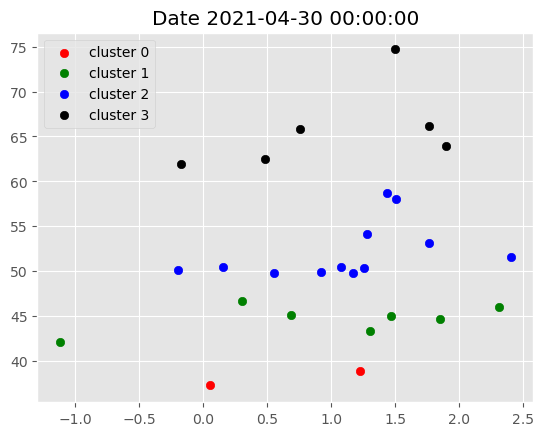

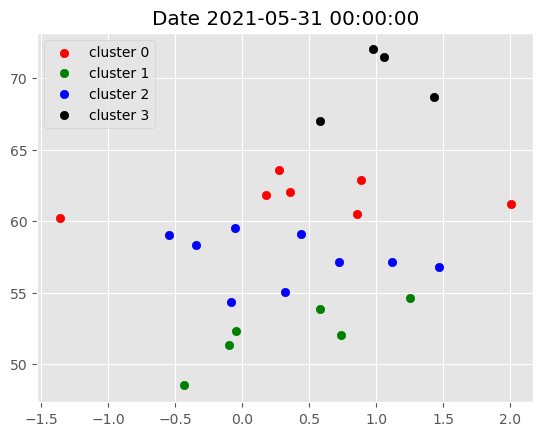

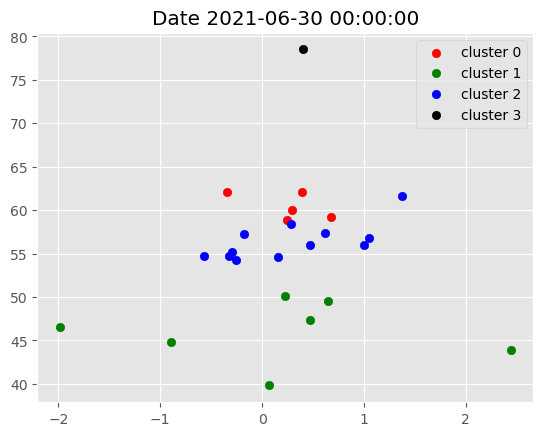

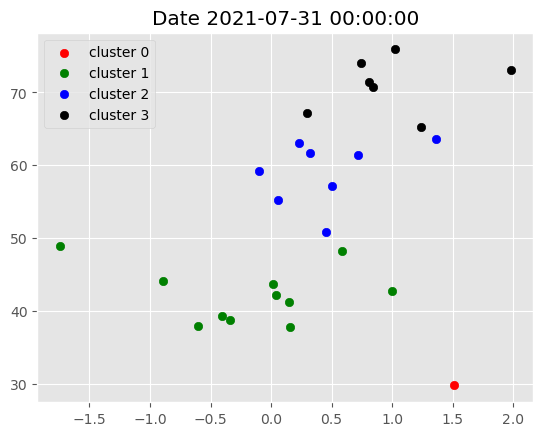

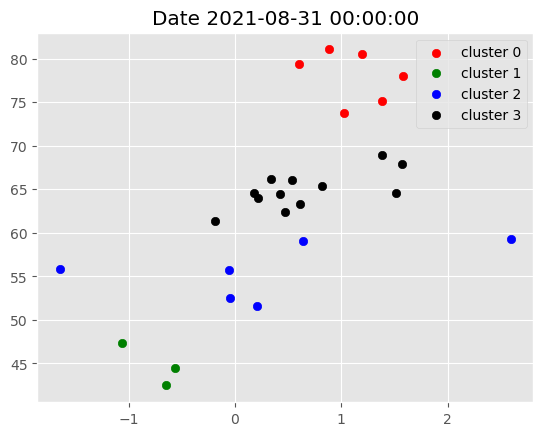

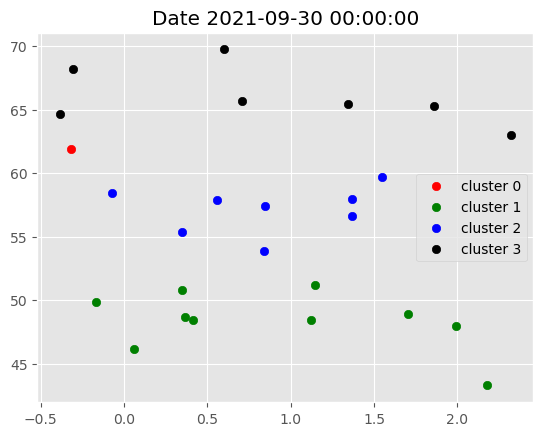

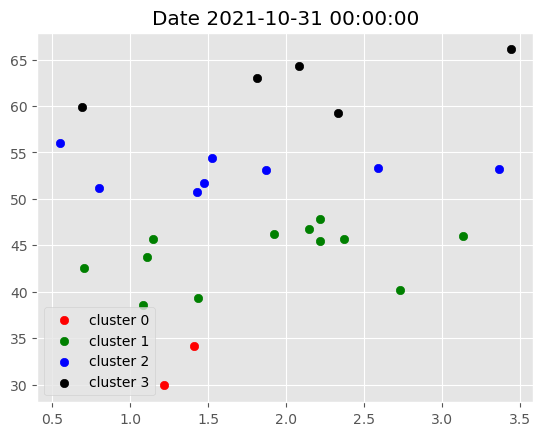

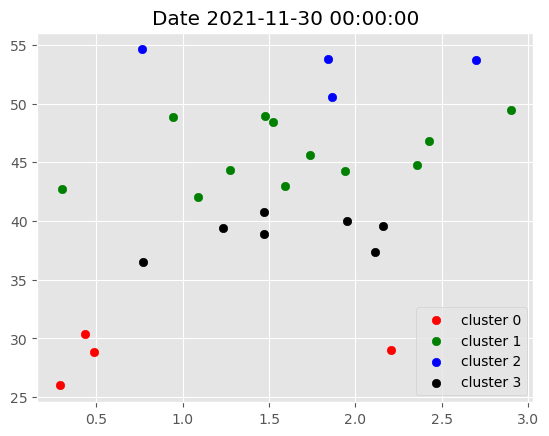

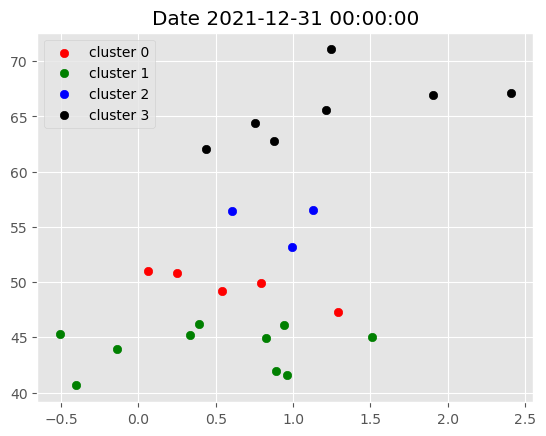

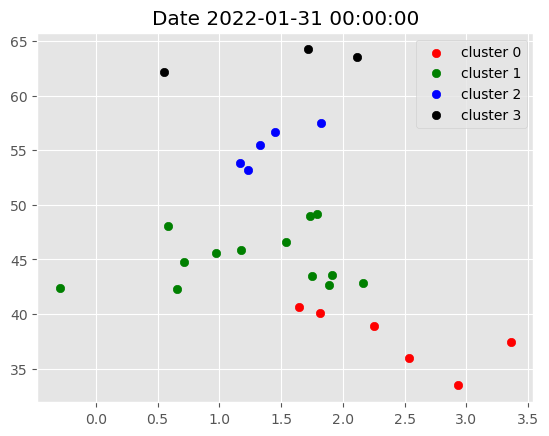

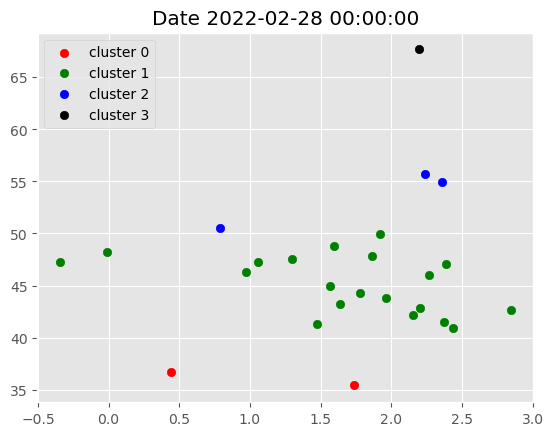

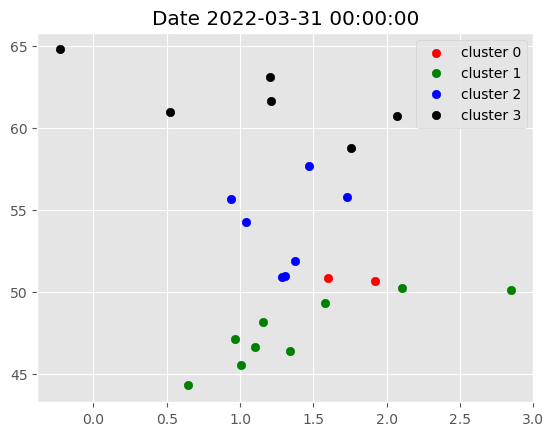

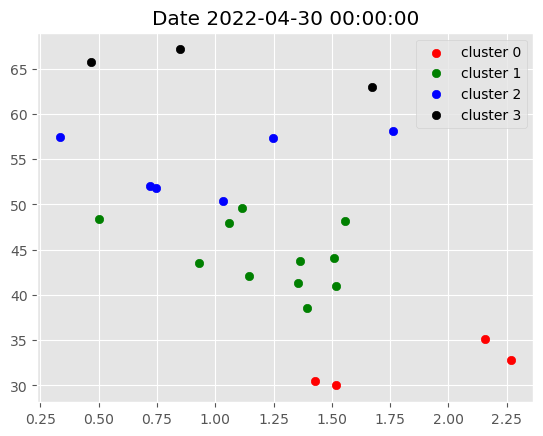

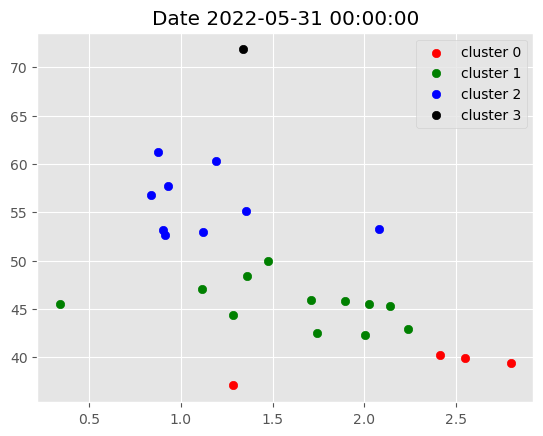

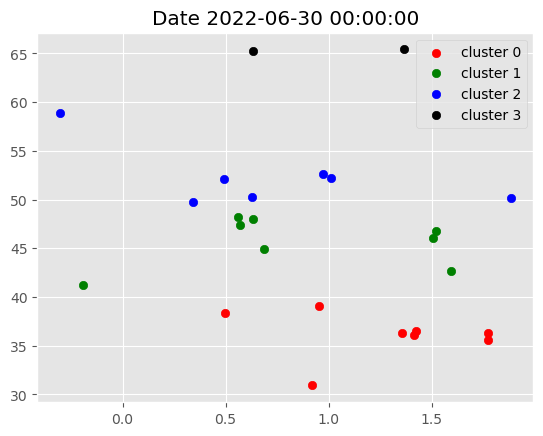

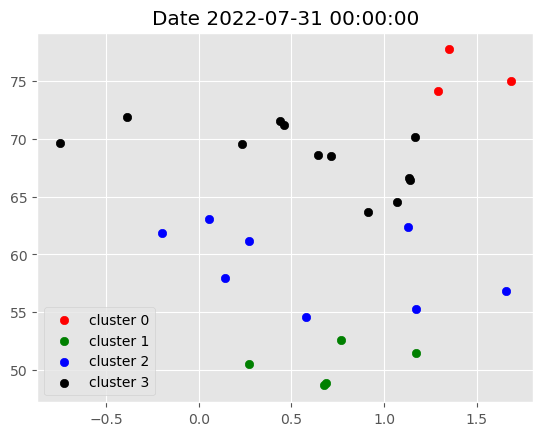

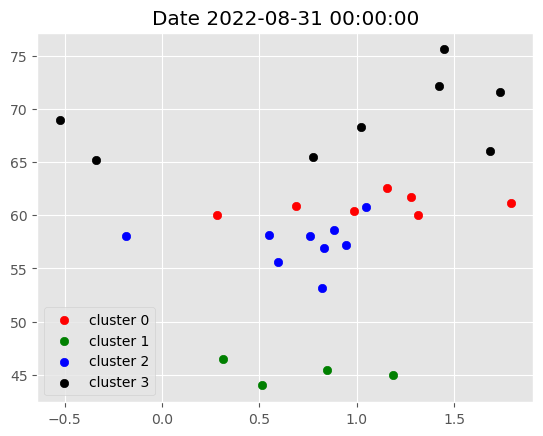

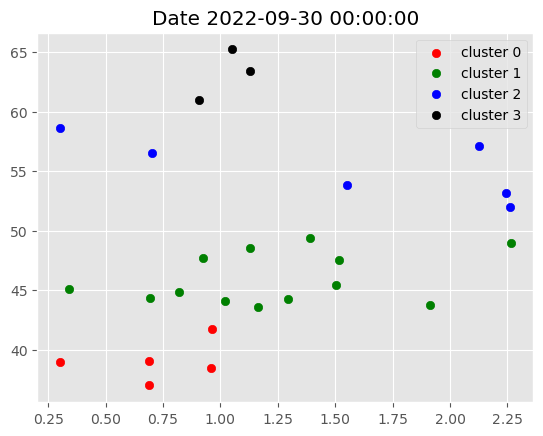

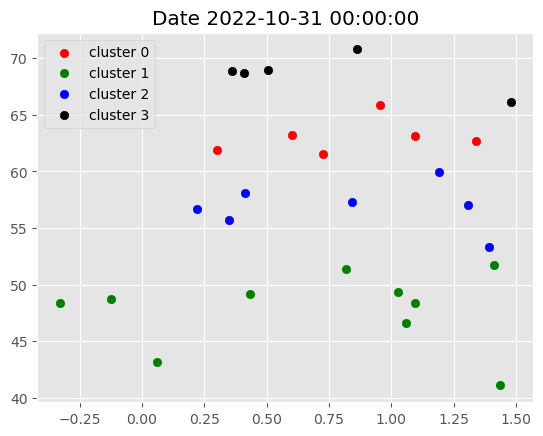

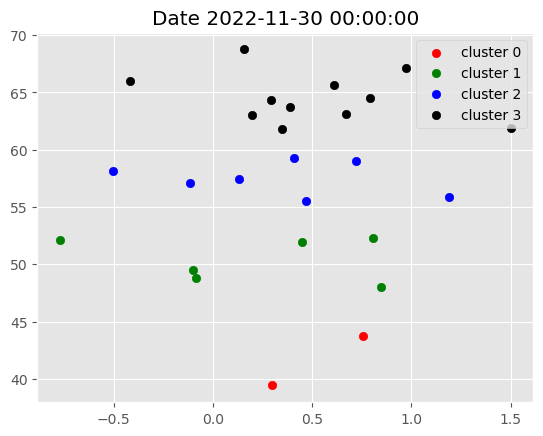

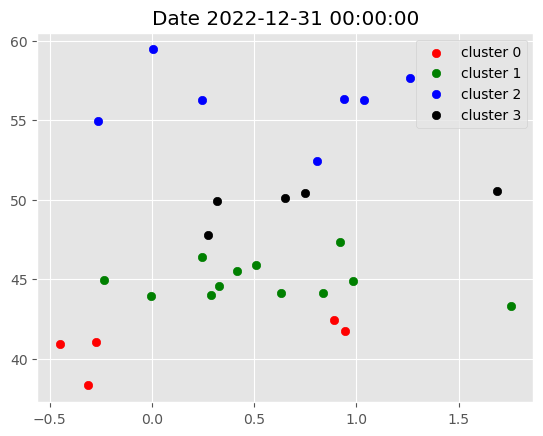

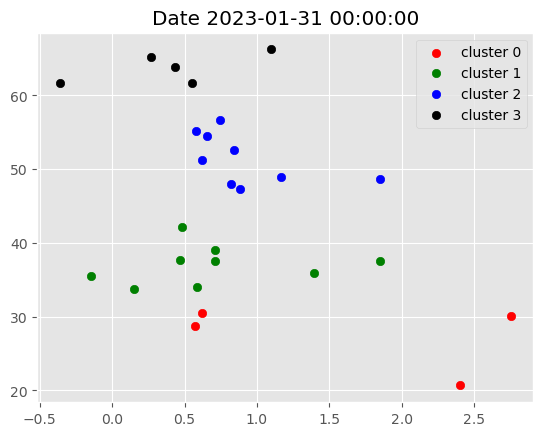

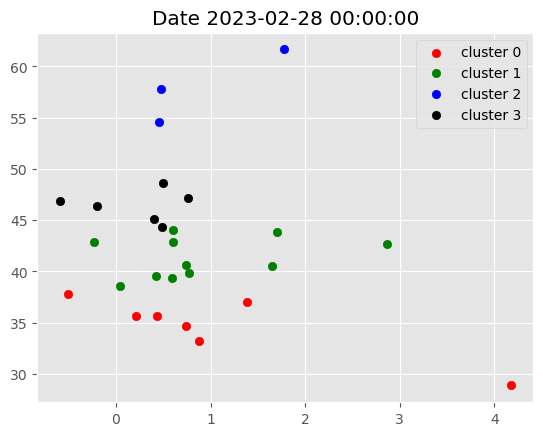

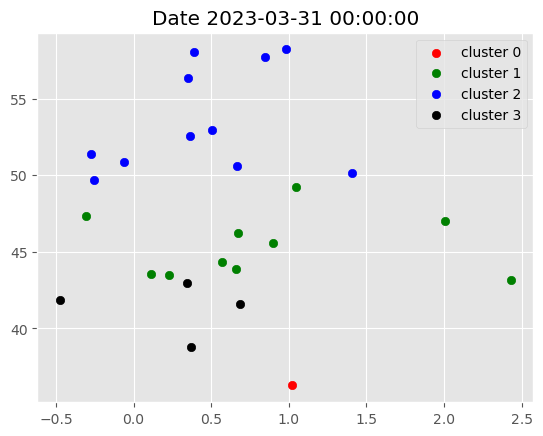

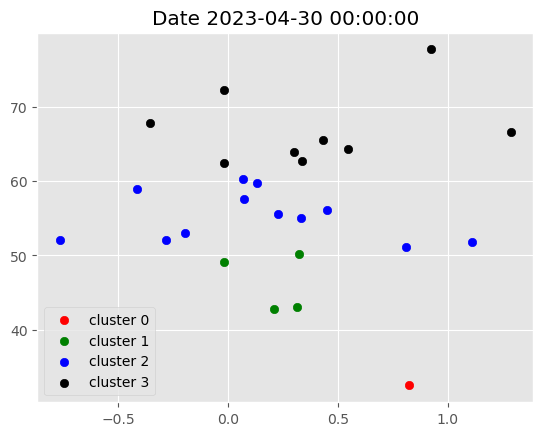

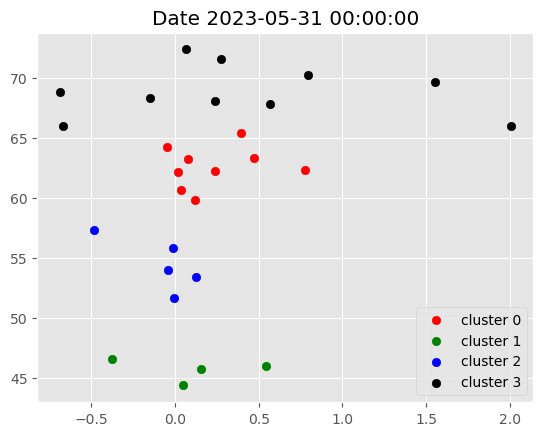

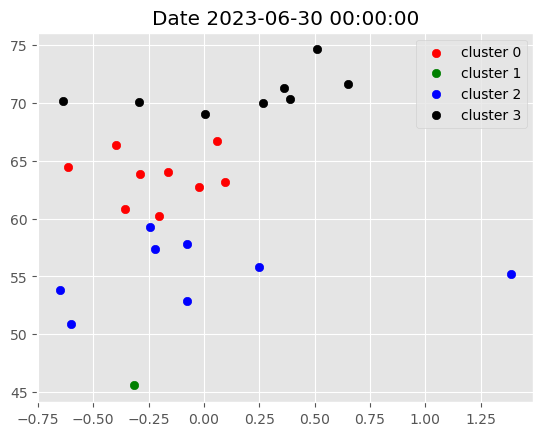

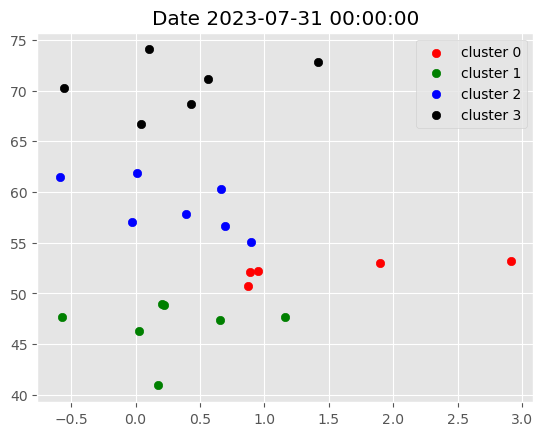

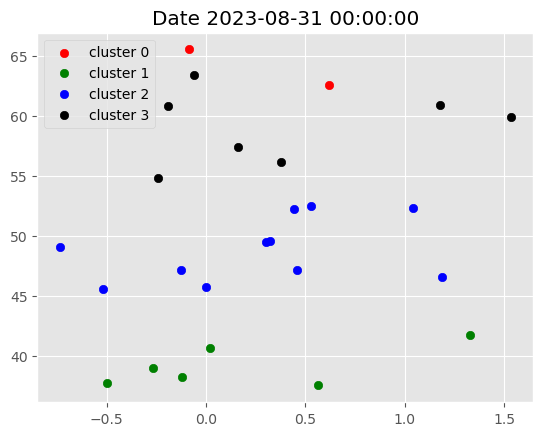

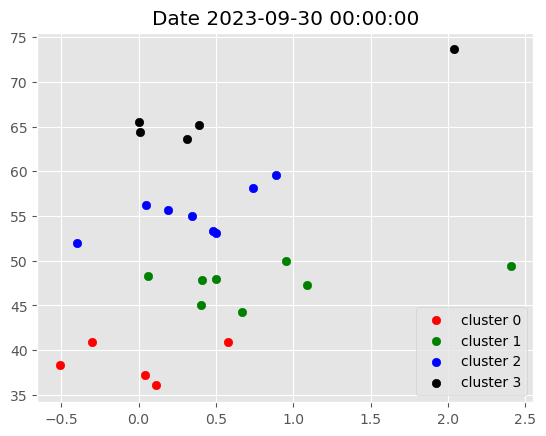

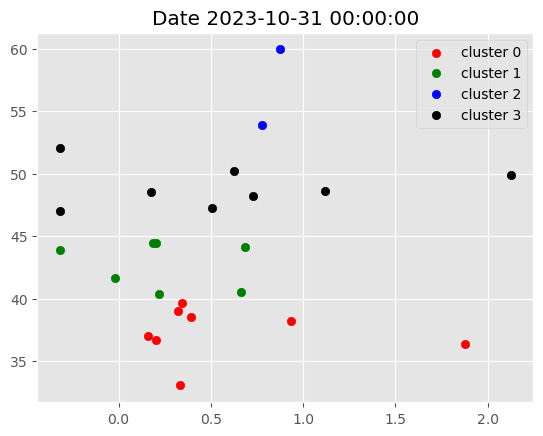

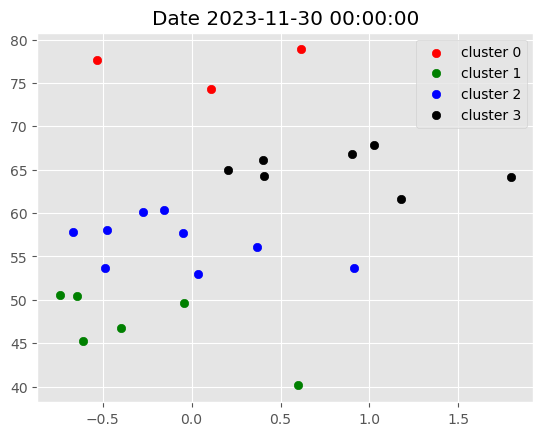

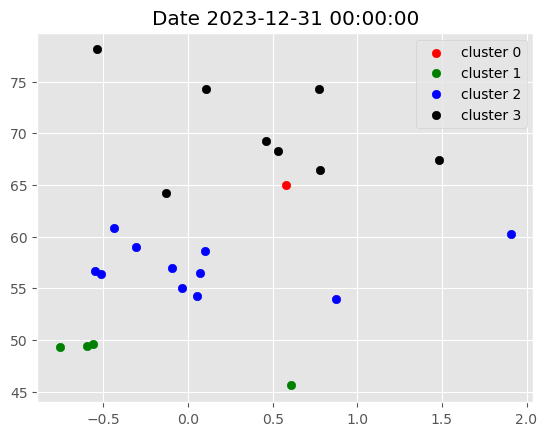

In [18]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

In [19]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

# 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization
* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [53]:
filtered_df = data[data['cluster']==1].copy()  # eveything lies here so use cluster value carefully

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {} # declare dictionary

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    
fixed_dates

{'2017-02-01': ['AXISBANK.NS',
  'HCLTECH.NS',
  'INFY.NS',
  'RELIANCE.NS',
  'SUNPHARMA.NS',
  'TCS.NS'],
 '2017-03-01': ['TATAMOTORS.NS'],
 '2017-04-01': ['AXISBANK.NS',
  'BHARTIARTL.NS',
  'ICICIBANK.NS',
  'M&M.NS',
  'SUNPHARMA.NS',
  'TATAMOTORS.NS',
  'TCS.NS'],
 '2017-05-01': ['TATAMOTORS.NS', 'TATASTEEL.NS'],
 '2017-06-01': ['SUNPHARMA.NS'],
 '2017-07-01': ['EICHERMOT.NS',
  'HCLTECH.NS',
  'HINDALCO.NS',
  'INFY.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'M&M.NS',
  'SUNPHARMA.NS',
  'TCS.NS'],
 '2017-08-01': ['ITC.NS', 'SUNPHARMA.NS', 'TATAMOTORS.NS'],
 '2017-09-01': ['AXISBANK.NS',
  'INFY.NS',
  'ITC.NS',
  'KOTAKBANK.NS',
  'LT.NS',
  'M&M.NS',
  'SBIN.NS',
  'SUNPHARMA.NS'],
 '2017-10-01': ['ADANIPORTS.NS',
  'BHARTIARTL.NS',
  'BPCL.NS',
  'HEROMOTOCO.NS',
  'HINDUNILVR.NS',
  'INFY.NS',
  'LT.NS',
  'RELIANCE.NS',
  'TCS.NS'],
 '2017-11-01': ['BAJFINANCE.NS',
  'HCLTECH.NS',
  'HDFCBANK.NS',
  'INDUSINDBK.NS',
  'ITC.NS',
  'KOTAKBANK.NS'],
 '2017-12-01': ['ADANIPORTS.NS',


# Define portfolio optimization function
* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [44]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()

In [45]:
stocks = data.index.get_level_values('ticker').unique().tolist()
new_df= yf.download(tickers= stocks,
                    start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)
                    ,end=data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%%**********************]  33 of 33 completed


Adj Close                                           \
            ADANIENT.NS ADANIPORTS.NS ASIANPAINT.NS  AXISBANK.NS   
Date                                                               
2016-02-01    39.376984    211.383301    840.552979   390.272919   
2016-02-02    38.056499    203.878265    835.911438   382.062775   
2016-02-03    38.003685    200.962326    818.103882   371.946716   
2016-02-04    38.162140    206.220612    842.399719   374.097046   
2016-02-05    38.928028    201.822769    851.777222   390.517212   
...                 ...           ...           ...          ...   
2023-11-24  2225.449951    795.549988   3136.149902  1008.500000   
2023-11-28  2423.500000    837.700012   3148.350098  1021.150024   
2023-11-29  2396.600098    835.549988   3148.350098  1060.150024   
2023-11-30  2358.550049    825.500000   3119.899902  1074.250000   
2023-12-01  2362.699951    827.799988   3173.399902  1104.650024   

                                                                               \
           BAJAJFINSV.NS BAJFINANCE.NS BHARTIARTL.NS     BPCL.NS   DRREDDY.NS   
Date                                                                            
2016-02-01    185.554138    585.049683    261.711273  192.587494  2855.049805   
2016-02-02    181.028687    566.362366    266.652557  188.736420  2853.177734   
2016-02-03    187.047699    621.751953    264.534851  184.130630  2815.553223   
2016-02-04    187.271744    618.258301    268.461426  184.618973  2815.880615   
2016-02-05    190.039780    652.801941    271.064423  187.116058  2909.894531   
...                  ...           ...           ...         ...          ...   
2023-11-24   1617.250000   7020.799805    973.150024  410.600006  5646.149902   
2023-11-28   1654.400024   7127.549805    984.900024  424.500000  5675.799805   
2023-11-29   1653.500000   7130.100098    995.400024  428.649994  5715.350098   
2023-11-30   1673.500000   7121.899902   1014.700012  435.700012  5788.149902   
2023-12-01   1685.949951   7259.350098   1014.700012  438.000000  5749.399902   

                         ...      Volume                                       \
           EICHERMOT.NS  ... RELIANCE.NS   SBIN.NS SUNPHARMA.NS TATAMOTORS.NS   
Date                     ...                                                    
2016-02-01  1620.984619  ...     4577528  22915269      3252050       6563774   
2016-02-02  1632.685791  ...     6816943  35957332      2676955       9179304   
2016-02-03  1590.637085  ...     7241614  24132003      2630864       6685445   
2016-02-04  1603.942871  ...     8401043  23811109      2287218       6086981   
2016-02-05  1720.224854  ...     9690760  22732245      2250196       9236577   
...                 ...  ...         ...       ...          ...           ...   
2023-11-24  3849.050049  ...     3374743   6529851      1376695       6951690   
2023-11-28  3826.699951  ...     6896087   8153314       886708      16015860   
2023-11-29  3812.250000  ...     6265653  10299034      1813462      16122864   
2023-11-30  3896.899902  ...    14219992  19758998      4672807      24275245   
2023-12-01  3891.199951  ...     7171421  10614230      1749751      10565415   

                                                                           
           TATASTEEL.NS   TCS.NS TECHM.NS TITAN.NS ULTRACEMCO.NS WIPRO.NS  
Date                                                                       
2016-02-01     46400199  1495274  2717866   659748        240216  4018593  
2016-02-02     88046083  1475588  5733789   757686        201113  3427580  
2016-02-03     81780438  1308692  2019903   723244        135537  1606738  
2016-02-04    122903030  1250046  1465102  1519516        103058  2804991  
2016-02-05    270834540  1402996  1196754  1549307        127269  2871047  
...                 ...      ...      ...      ...           ...      ...  
2023-11-24     14719450  1989733   884921   589530        197278  3125283  
2023-11-28     18377843  168919

In [ ]:
data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12)

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [46]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        if success==False:
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'index']).unstack().stack()

        temp_df.index.names = ['date', 'ticker']

        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']

        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()

portfolio_df
    

Max Sharpe Optimization failed for 2017-02-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-03-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-04-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-05-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-06-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-07-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-08-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-09-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-10-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-11-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2017-12-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-01-01, Continuing with Equal-Weights
Max Sharpe Optimization failed for 2018-02-01, Continuing with Equal-Weights

Strategy Return
date                       
2017-02-01        -0.002475
2017-02-02         0.014746
2017-02-03         0.005353
2017-02-06         0.010000
2017-02-07        -0.004930
...                     ...
2023-11-24         0.000270
2023-11-28         0.023055
2023-11-29         0.002118
2023-11-30        -0.006452
2023-12-01         0.011545

[1689 rows x 1 columns]

<Axes: xlabel='date'>

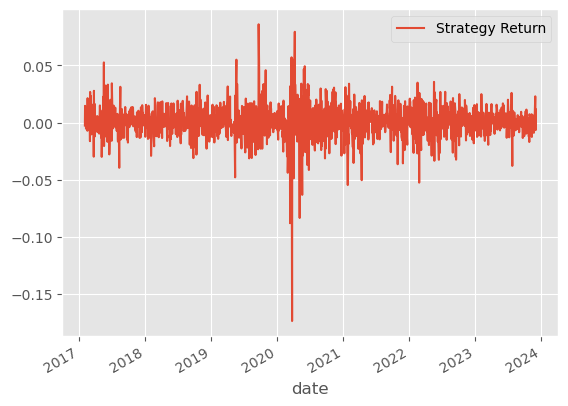

In [47]:
portfolio_df.plot()

In [48]:
pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T

BAJFINANCE.NS  INDUSINDBK.NS  KOTAKBANK.NS  SBIN.NS
0           0.25           0.25          0.25     0.25

In [50]:
nifty = yf.download(tickers='^NSEI',
                  start='2015-01-01',
                  end=dt.date.today())

nifty_ret = np.log(nifty[['Adj Close']]).diff().dropna().rename({'Adj Close':'nifty Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(nifty_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


Strategy Return  nifty Buy&Hold
2017-02-01        -0.002475        0.017954
2017-02-02         0.014746        0.002046
2017-02-03         0.005353        0.000767
2017-02-06         0.010000        0.006852
2017-02-07        -0.004930       -0.003728
...                     ...             ...
2023-11-24         0.000270       -0.000369
2023-11-28         0.023055        0.004788
2023-11-29         0.002118        0.010349
2023-11-30        -0.006452        0.001817
2023-12-01         0.011545        0.006671

[1685 rows x 2 columns]

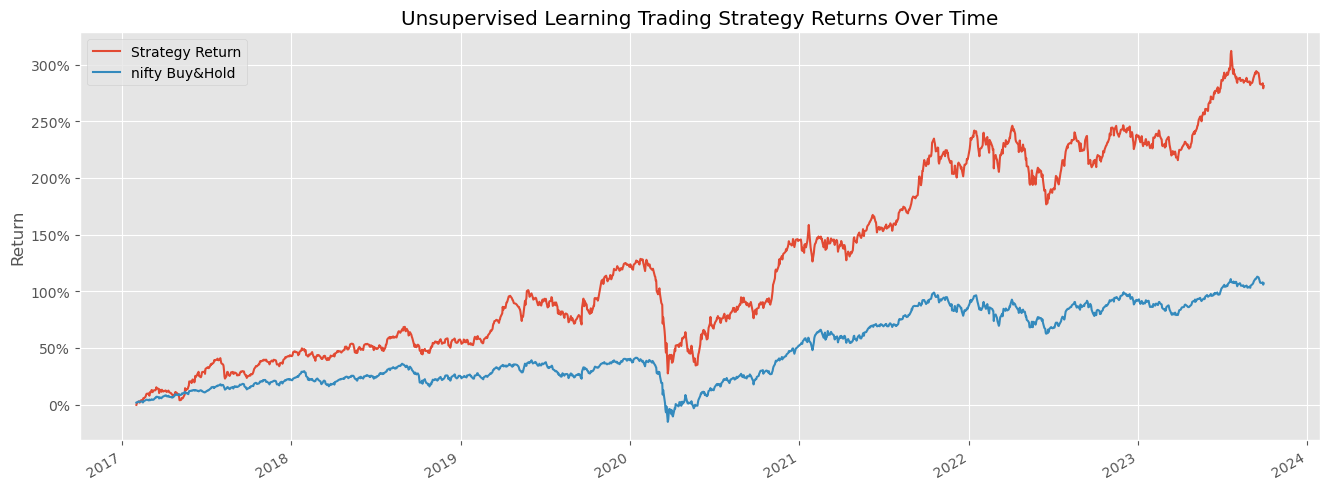

In [51]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()